## Librerías

In [1]:
import os
import random
import shap
import itertools
import hashlib

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, auc
from sklearn.base import clone
from scipy.stats import mannwhitneyu

from xgboost import XGBClassifier

from tqdm.notebook import tqdm

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(42)

## Data

In [3]:
exist_data = pd.read_csv('../Data/exist.csv', index_col=0).T
fold_data = pd.read_csv('../Data/fold.csv', index_col=0).T
metadata = pd.read_csv('../Data/metadata.csv')

peptide_info = pd.read_csv('../Data/peptide_libraries_info.csv', index_col=0)

## Funciones aux

### OG modificadas

In [4]:
def split_xy_df_and_filter_by_threshold(xy_df: pd.DataFrame, bottom_threshold: float):
    xy_df = xy_df.copy()

    peptide_prefixes = ['twist_', 'agilent_', 'corona2_']

    peptide_cols = [col for col in xy_df.columns if any(col.startswith(p) for p in peptide_prefixes)]
    non_peptide_cols = [col for col in xy_df.columns if col not in peptide_cols]

    peptides_df = xy_df[peptide_cols]
    filter_function = pd.notnull if peptides_df.isnull().any().any() else lambda x: x != 0
    kept_peptides = peptides_df.loc[:, peptides_df.map(filter_function).mean().ge(bottom_threshold)]

    xy_df_filtered = pd.concat([kept_peptides, xy_df[non_peptide_cols]], axis=1)

    y = xy_df_filtered.iloc[:, -1]
    x = xy_df_filtered.iloc[:, :-1]

    if x.shape[1] == 0:
        return None 
    
    return x, y

def get_cross_validation_predictions(x, y, estimator):

    proba = cross_val_predict(
        estimator, x, y,
        cv=LeaveOneOut(),
        method='predict_proba',
        n_jobs=-1
    )[:, 1]                                        # Probabilidad de pertenecer a la clase positiva

    df = pd.DataFrame({
        'proba': proba,
        'true_label': y.values
    }, index=y.index)

    original_index_name = df.index.name
    df = df.reset_index() 
    index_col_name = original_index_name if original_index_name is not None else 'index'
    df = df.sort_values(by=['true_label', 'proba', index_col_name])

    return df

def add_level_for_predictions(level_range, level_name, level_function, *args, **kwargs):

    res = []

    for level_value in level_range:
        kwargs[level_name] = level_value
        level_res = level_function(*args, **kwargs)

        num_index_cols = level_res.reset_index().shape[1] - level_res.shape[1]
        level_res[level_name] = level_value
        level_res.set_index(level_name, append=True, inplace=True)
        level_res = level_res.reorder_levels([-1] + list(range(num_index_cols)))
        
        res.append(level_res)

    if res:
        return pd.concat(res)
    
    else:
        return pd.DataFrame() 

def get_predictions_for_all_thresholds(estimator, df):

    def foo(threshold_percent):

        resultado = split_xy_df_and_filter_by_threshold(df, bottom_threshold=threshold_percent / 100)
        
        if resultado is None:
            print(f'No queda ningúna columna tras usar threshold {threshold_percent}')
            return pd.DataFrame()
        
        x, y = resultado

        df_preds = get_cross_validation_predictions(x, y, estimator)
        df_preds['num_peptides'] = x.shape[1]

        return df_preds

    return add_level_for_predictions(
        level_range=[5, 30],
        level_name='threshold_percent',
        level_function=foo
    )

### Nuevas

In [5]:
def get_peptides_in_subgroup(df, peptide_info, subgroup_name):

    available_peptides = set(df.columns)
    peptides_in_group = peptide_info[peptide_info[subgroup_name] == True].index
    
    return sorted(available_peptides.intersection(peptides_in_group))

def add_clinical_variables(df_peptides, metadata, vars_to_include):
    df = df_peptides.copy()
    clinical_vars = metadata[vars_to_include].reset_index(drop=True)
    df = df.reset_index(drop=True)
    df = pd.concat([df.iloc[:, :-1], clinical_vars, df.iloc[:, -1]], axis=1)
    return df

## Main

### Exist data

In [56]:
subgroup_dfs = {}

full_df = exist_data.copy()
full_df['disease'] = metadata['disease'].values
subgroup_dfs['all'] = full_df

for subgroup in peptide_info.columns:

    full_df = exist_data.copy()
    valid_cols = get_peptides_in_subgroup(full_df, peptide_info, subgroup)

    if len(valid_cols) == 0:
        continue

    subset_df = exist_data[valid_cols].copy()
    subset_df['disease'] = metadata['disease'].values
    subgroup_dfs[subgroup] = subset_df

In [7]:
rng = np.random.default_rng(42)

all_auc_results = []
bootstrap_auc_records = []

for subgroup_name in sorted(subgroup_dfs):

    df = subgroup_dfs[subgroup_name]
    xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
    preds = get_predictions_for_all_thresholds(xgb_model, df)

    for threshold, group_df in preds.groupby(level='threshold_percent', sort=True):

        aucs = []
   
        for i in range(50):

            unique_string = f"{subgroup_name}-{threshold}-{i}"
            seed_hash = int(hashlib.sha256(unique_string.encode('utf-8')).hexdigest(), 16)
            seed = seed_hash % (2**32 - 1) 
            
            sample = group_df.sample(n=len(group_df), replace=True, random_state=rng)

            try:
                auc_val = roc_auc_score(sample['true_label'], sample['proba'])
                aucs.append(auc_val)

                bootstrap_auc_records.append({
                    'subgroup': subgroup_name,
                    'threshold_percent': threshold,
                    'auc': auc_val
                })
                
            except ValueError:
                continue

        if aucs:
            all_auc_results.append({
                'subgroup': subgroup_name,
                'threshold_percent': threshold,
                'mean_auc': np.mean(aucs),
                'std_auc': np.std(aucs),
                'num_peptides': group_df['num_peptides'].iloc[0]
            })

auc_summary_df_all_subgroups_exist = pd.DataFrame(all_auc_results)
bootstrap_auc_df_all_subgroups_exist = pd.DataFrame(bootstrap_auc_records)

No queda ningúna columna tras usar threshold 30
No queda ningúna columna tras usar threshold 30
No queda ningúna columna tras usar threshold 30


#### Gráficos

##### Barplots

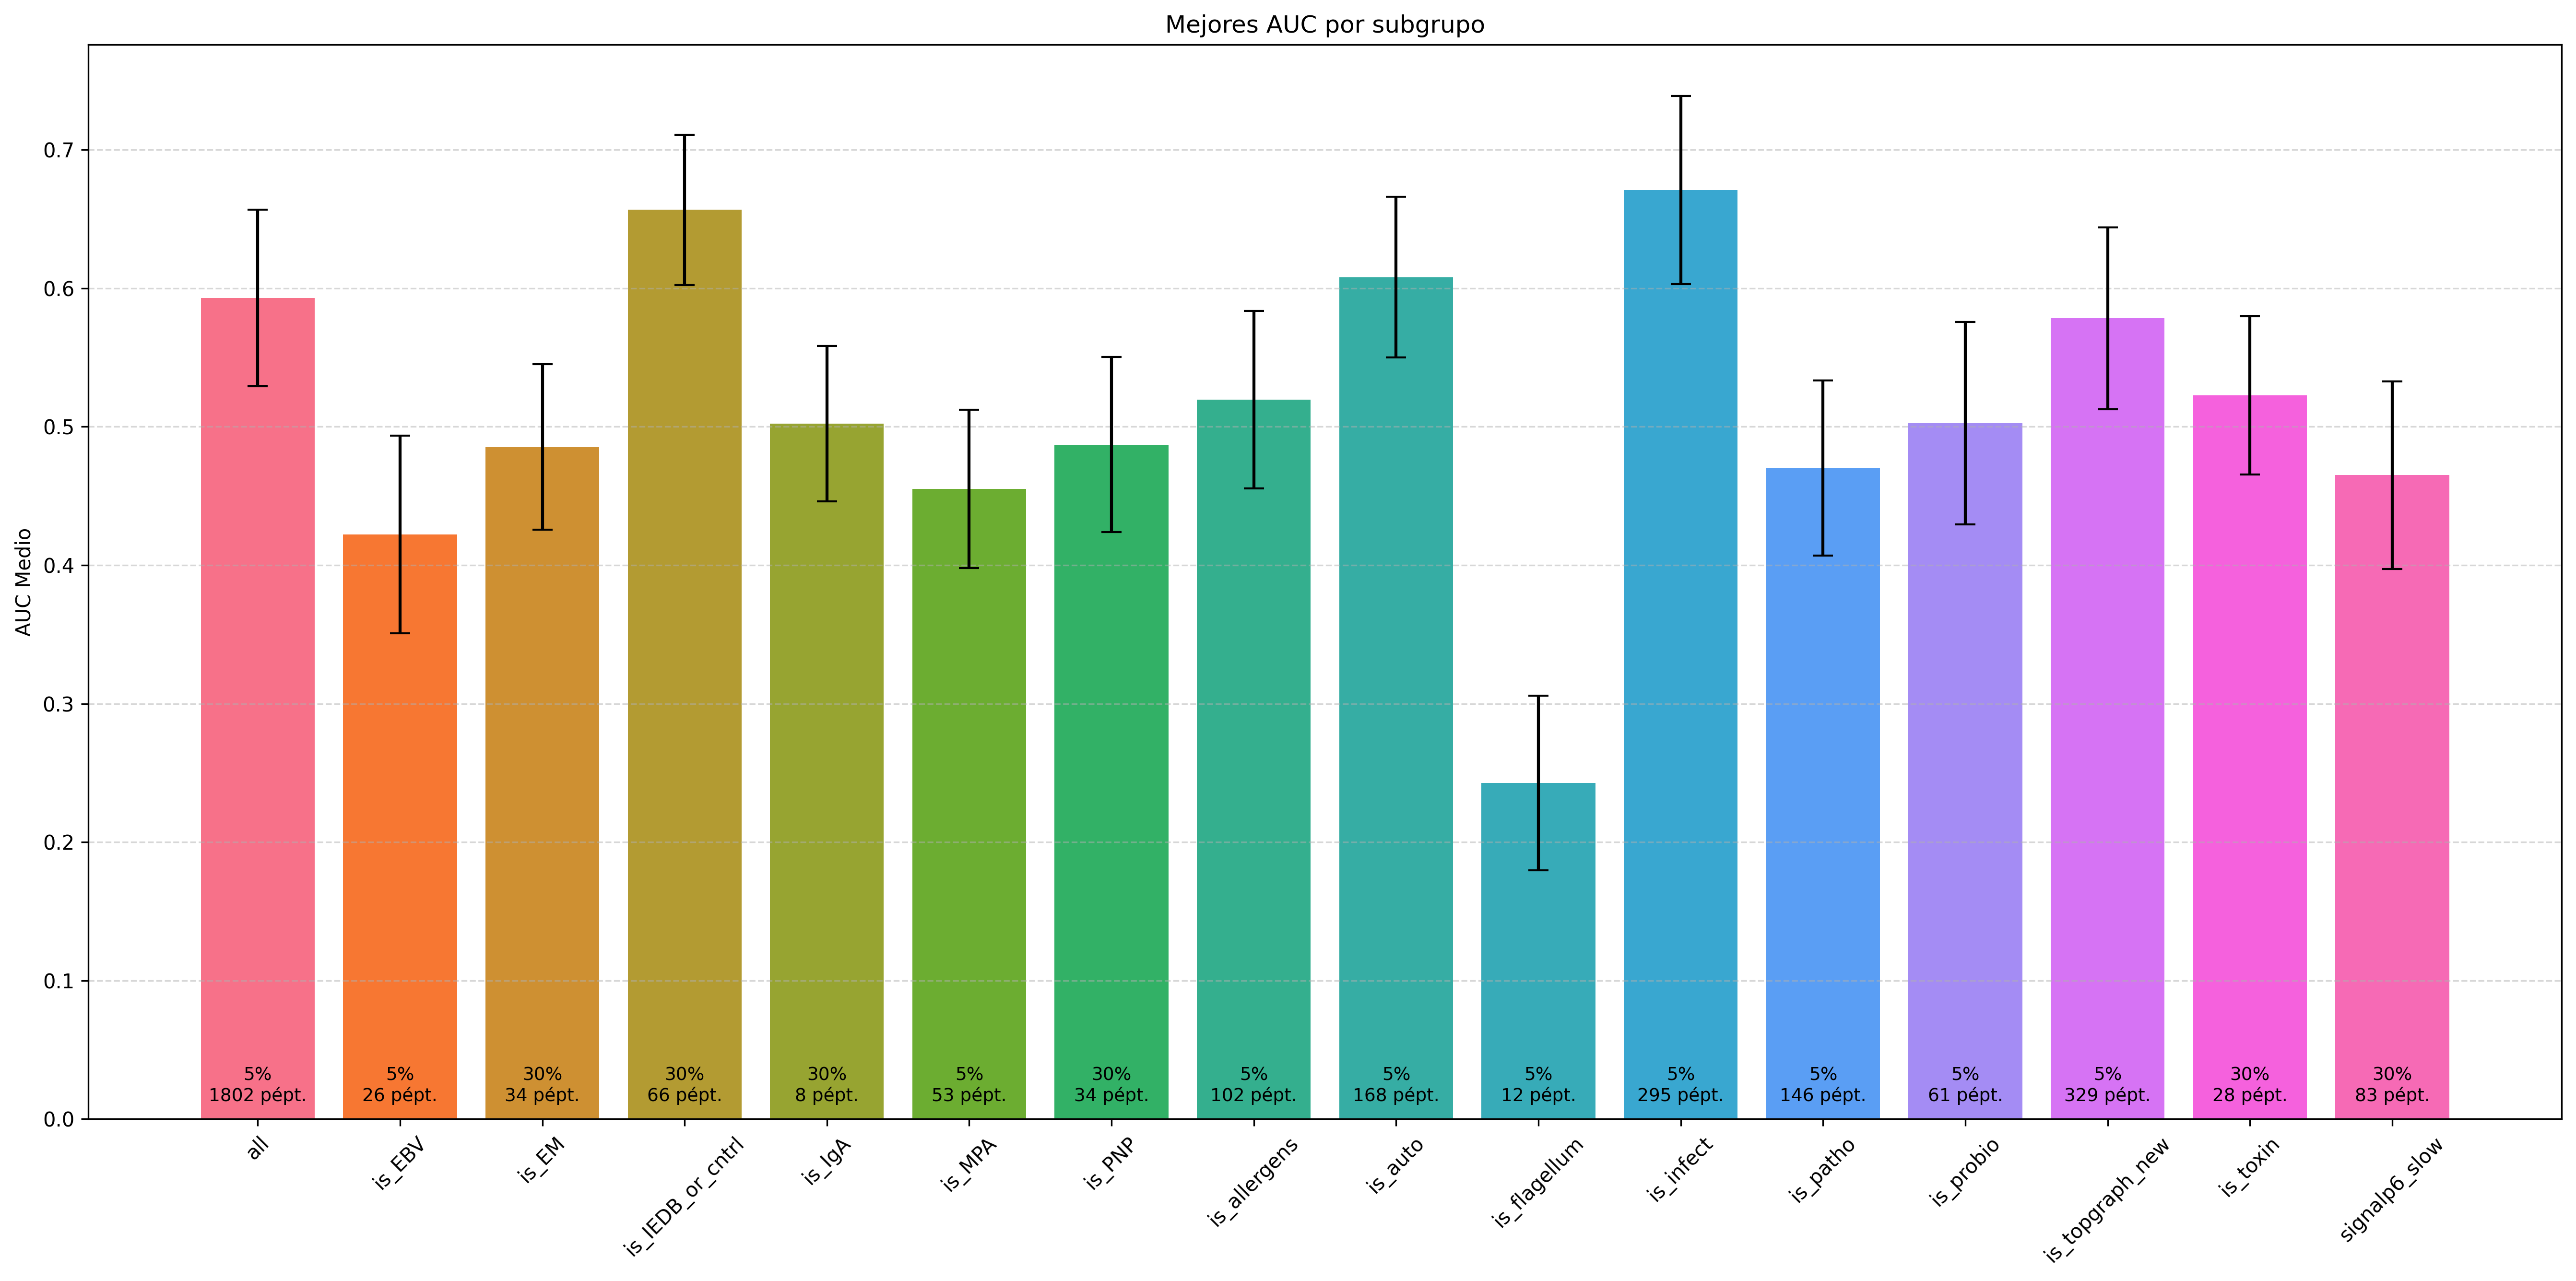

In [8]:
best_auc_df = auc_summary_df_all_subgroups_exist.loc[auc_summary_df_all_subgroups_exist.groupby('subgroup')['mean_auc'].idxmax()]

n = len(best_auc_df)

plt.figure(figsize=(18, 9), dpi=300)
bars = plt.bar(
    best_auc_df['subgroup'], 
    best_auc_df['mean_auc'], 
    yerr=best_auc_df['std_auc'], 
    capsize=5,
    color=sns.color_palette("husl", n_colors=n),
)

for bar, threshold, n_pep in zip(bars, best_auc_df['threshold_percent'], best_auc_df['num_peptides']):
    height = bar.get_height()
    label = f'{threshold}%\n{n_pep} pépt.'
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        0.01, 
        label, 
        ha='center', 
        va='bottom', 
        fontsize=9
    )

plt.ylabel('AUC Medio')
plt.title('Mejores AUC por subgrupo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

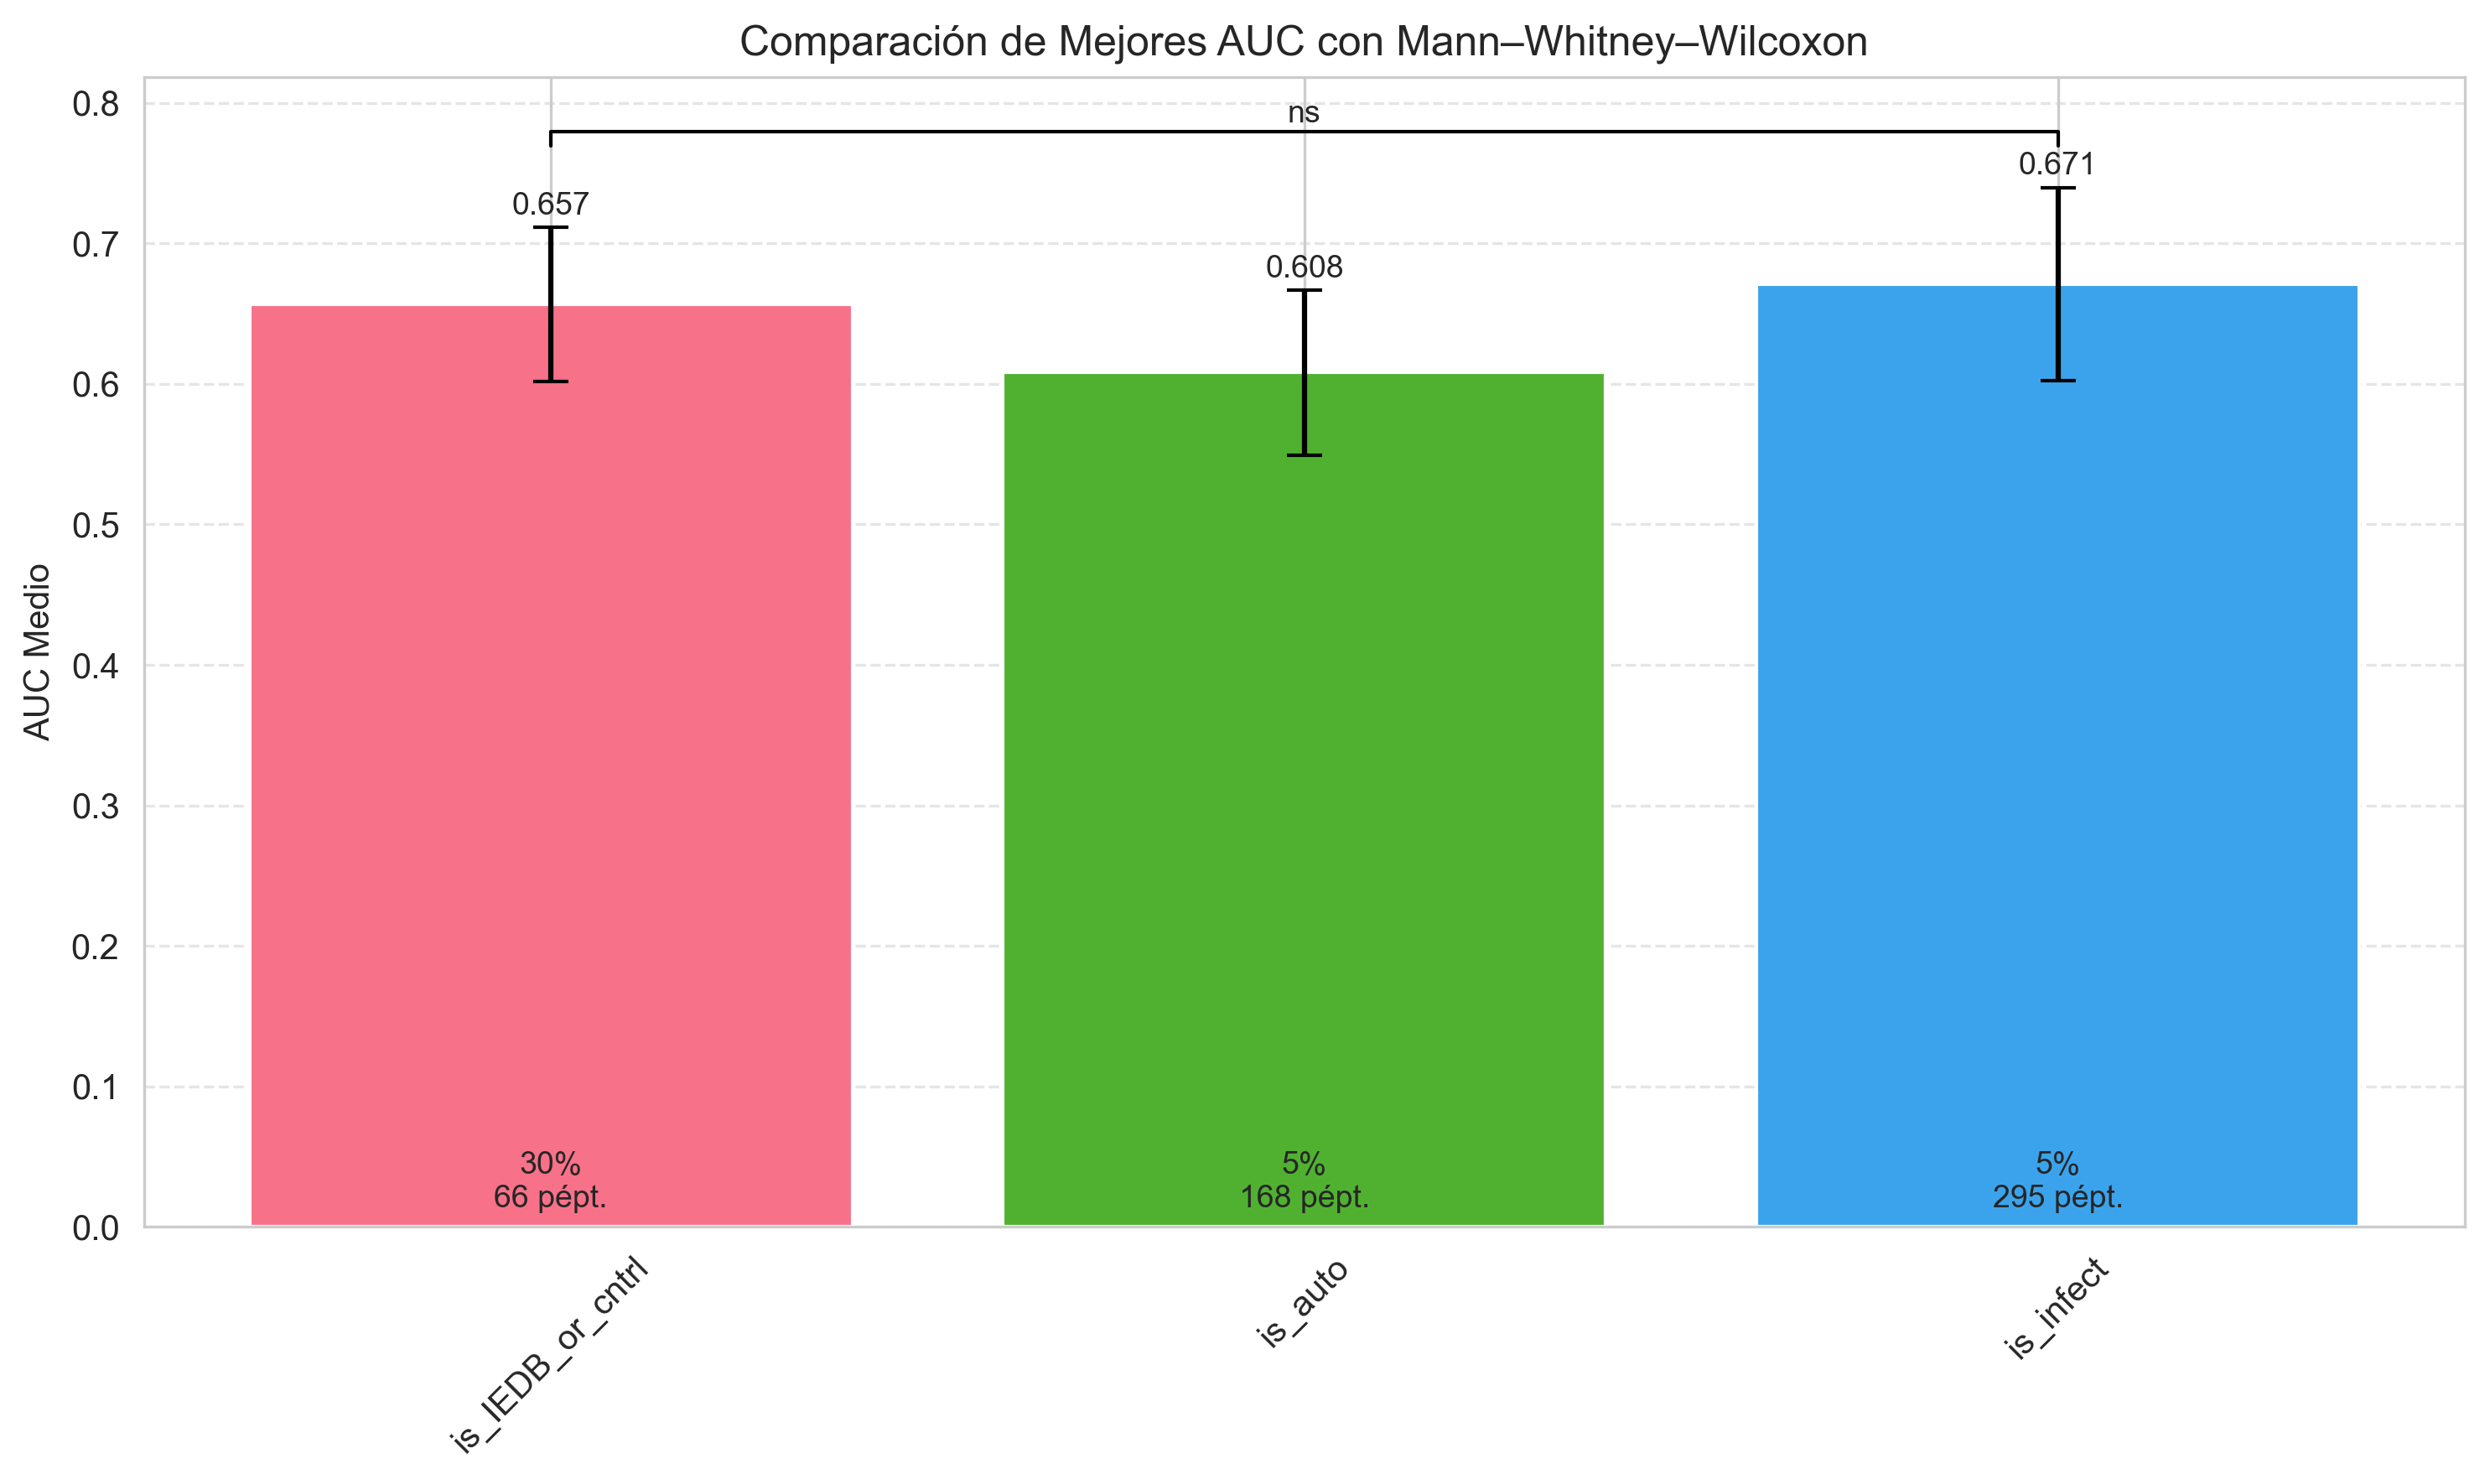

In [9]:
best_auc_df = auc_summary_df_all_subgroups_exist.loc[auc_summary_df_all_subgroups_exist.groupby('subgroup')['mean_auc'].idxmax()]
best_auc_df = best_auc_df[best_auc_df['mean_auc'] > 0.6]

filtered_bootstrap_df = pd.merge(
    bootstrap_auc_df_all_subgroups_exist,
    best_auc_df[['subgroup', 'threshold_percent']],
    on=['subgroup', 'threshold_percent']
)

summary_df = filtered_bootstrap_df.groupby('subgroup')['auc'].agg(['mean', 'std']).reset_index()

summary_df = pd.merge(summary_df, best_auc_df[['subgroup', 'threshold_percent', 'num_peptides']], on='subgroup')

pairwise_results = {}
subgroups = summary_df['subgroup'].tolist()

for g1, g2 in itertools.combinations(subgroups, 2):
    aucs_g1 = filtered_bootstrap_df.loc[filtered_bootstrap_df['subgroup'] == g1, 'auc']
    aucs_g2 = filtered_bootstrap_df.loc[filtered_bootstrap_df['subgroup'] == g2, 'auc']
    stat, p = mannwhitneyu(aucs_g1, aucs_g2, alternative='two-sided')
    pairwise_results[(g1, g2)] = p

plt.figure(figsize=(10, 6), dpi=300)
sns.set_style("whitegrid")

bars = plt.bar(
    summary_df['subgroup'],
    summary_df['mean'],
    yerr=summary_df['std'],
    capsize=5,
    color=sns.color_palette("husl", len(summary_df))
)

for bar, mean, std, threshold, n_pep in zip(
    bars,
    summary_df['mean'],
    summary_df['std'],
    summary_df['threshold_percent'],
    summary_df['num_peptides']
):
    # Etiqueta superior
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        mean + std + 0.005,
        f"{mean:.3f}",
        ha='center',
        va='bottom',
        fontsize=9
    )
    # Etiqueta inferior
    label = f'{threshold}%\n{n_pep} pépt.'
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        0.01,
        label,
        ha='center',
        va='bottom',
        fontsize=9
    )

y_max = (summary_df['mean'] + summary_df['std']).max()
step = 0.05
y_pos = y_max + 0.03

for (g1, g2), p in pairwise_results.items():
    if p > 0.05:
        i = summary_df.index[summary_df['subgroup'] == g1][0]
        j = summary_df.index[summary_df['subgroup'] == g2][0]
        x1, x2 = min(i, j), max(i, j)
        plt.plot([x1, x1, x2, x2], [y_pos, y_pos + 0.01, y_pos + 0.01, y_pos], lw=1, c='black')
        plt.text((x1 + x2) / 2, y_pos + 0.012, 'ns', ha='center', va='bottom', fontsize=9)
        y_pos += step

plt.ylabel('AUC Medio')
plt.title('Comparación de Mejores AUC con Mann–Whitney–Wilcoxon')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


##### SHAP

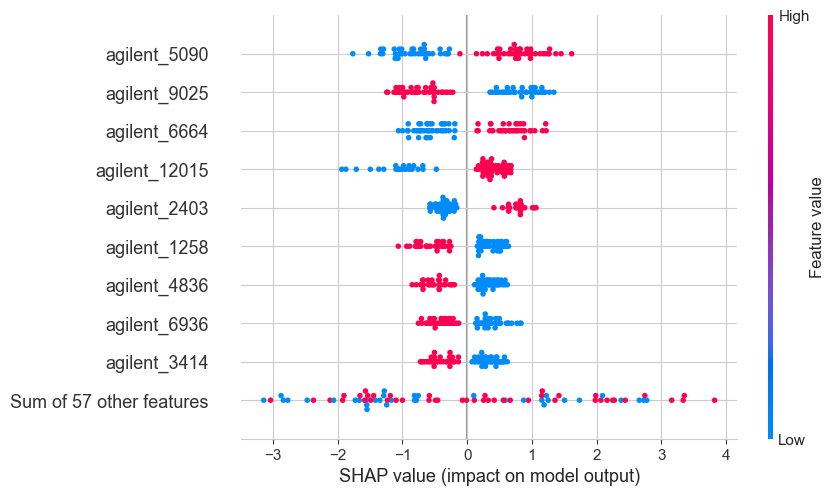

In [13]:
subgroup_name = "is_IEDB_or_cntrl"
threshold = 30
df = subgroup_dfs[subgroup_name]

x, y = split_xy_df_and_filter_by_threshold(df.copy(), bottom_threshold=threshold / 100)

model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
model.fit(x, y)

explainer = shap.TreeExplainer(model, x)
shap_values = explainer(x)
shap.plots.beeswarm(shap_values, max_display=10, show=True)


In [14]:
shap_df = pd.DataFrame(shap_values.values, columns=x.columns)
mean_shap = shap_df.abs().mean().to_frame(name='SHAP value')

df_with_labels = x.copy()

df_with_labels['disease'] = y.values
df_with_labels['disease'] = y.map({0: 'Ctrl.', 1: 'Dis.'})

grouped = df_with_labels.groupby('disease').mean().T * 100
grouped = grouped[['Dis.', 'Ctrl.']]

grouped['Ratio (log)'] = np.log10((grouped['Dis.'] + 1) / (grouped['Ctrl.'] + 1))

summary_df = (
    mean_shap
    .join(grouped)
    .sort_values('SHAP value', ascending=False)
)
summary_df.index.name = 'peptide_name'
summary_df.reset_index(inplace=True)

summary_df['Full Name'] = peptide_info.loc[summary_df['peptide_name'], 'full name'].values
summary_df['Description'] = peptide_info.loc[summary_df['peptide_name'], 'Description'].values
summary_df['Family'] = peptide_info.loc[summary_df['peptide_name'], 'family'].values

cols_order = ['peptide_name', 'Full Name', 'Description', 'Family', 'SHAP value', 'Dis.', 'Ctrl.', 'Ratio (log)']
summary_df = summary_df[cols_order]

In [15]:
summary_df.head(10)

,peptide_name,Full Name,Description,Family,SHAP value,Dis.,Ctrl.,Ratio (log)
0,agilent_5090,Capsid protein VP26 & capsid protein VP26 [Hum...,Small capsomere-interacting protein,Orthoherpesviridae,0.834307,57.5,45.0,0.104398
1,agilent_9025,pneumococcal histidine triad protein E & hydro...,Bvh-3,Streptococcaceae,0.795546,37.5,67.5,-0.250230
2,agilent_6664,positive (from uniprot): Rhinovirus B Genome ...,Genome polyprotein,Picornaviridae,0.630113,55.0,37.5,0.162727
3,agilent_12015,positive (exact): Human herpesvirus 1 Envelop...,NaN,Orthoherpesviridae,0.600532,80.0,65.0,0.088941
4,agilent_2403,phosphoprotein 150 & Large structural phosphop...,Large structural phosphoprotein,Orthoherpesviridae,0.495590,40.0,22.5,0.241716
5,agilent_1258,EBNA3C latent protein [Human gammaherpesvirus ...,Epstein-Barr nuclear antigen 6,Orthoherpesviridae,0.444323,37.5,42.5,-0.053029
6,agilent_4836,protease precursor,Gingipain R1,Porphyromonadaceae,0.408591,32.5,47.5,-0.160697
7,agilent_6936,nuclear protein EBNA2 & EBNA-2 & Epstein-Barr ...,Epstein-Barr nuclear antigen 2,Orthoherpesviridae,0.400885,40.0,57.5,-0.154372
8,agilent_3414,pneumococcal histidine triad protein E & hydro...,Bvh-3,Streptococcaceae,0.385685,35.0,55.0,-0.191886
9,agilent_12001,positive (exact): Human respiratory syncytial ...,NaN,Pneumoviridae,0.378399,65.0,47.5,0.133802


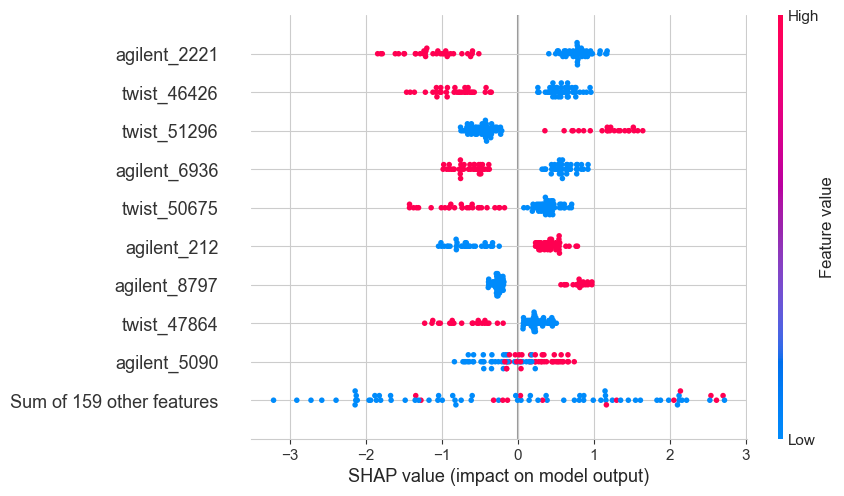

In [16]:
subgroup_name = "is_auto"
threshold = 5
df = subgroup_dfs[subgroup_name]

x, y = split_xy_df_and_filter_by_threshold(df.copy(), bottom_threshold=threshold / 100)

model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
model.fit(x, y)

explainer = shap.TreeExplainer(model, x)
shap_values = explainer(x)
shap.plots.beeswarm(shap_values, max_display=10, show=True)


In [17]:
shap_df = pd.DataFrame(shap_values.values, columns=x.columns)
mean_shap = shap_df.abs().mean().to_frame(name='SHAP value')

df_with_labels = x.copy()

df_with_labels['disease'] = y.values
df_with_labels['disease'] = y.map({0: 'Ctrl.', 1: 'Dis.'})

grouped = df_with_labels.groupby('disease').mean().T * 100
grouped = grouped[['Dis.', 'Ctrl.']]

grouped['Ratio (log)'] = np.log10((grouped['Dis.'] + 1) / (grouped['Ctrl.'] + 1))

summary_df = (
    mean_shap
    .join(grouped)
    .sort_values('SHAP value', ascending=False)
)
summary_df.index.name = 'peptide_name'
summary_df.reset_index(inplace=True)

summary_df['Full Name'] = peptide_info.loc[summary_df['peptide_name'], 'full name'].values
summary_df['Description'] = peptide_info.loc[summary_df['peptide_name'], 'Description'].values
summary_df['Family'] = peptide_info.loc[summary_df['peptide_name'], 'family'].values

cols_order = ['peptide_name', 'Full Name', 'Description', 'Family', 'SHAP value', 'Dis.', 'Ctrl.', 'Ratio (log)']
summary_df = summary_df[cols_order]

In [18]:
summary_df.head(10)

,peptide_name,Full Name,Description,Family,SHAP value,Dis.,Ctrl.,Ratio (log)
0,agilent_2221,Genome polyprotein (4/6) & polyprotein (6/9) &...,Genome polyprotein,Picornaviridae,0.933391,32.5,50.0,-0.182525
1,twist_46426,NaN,nuclear protein EBNA2,Orthoherpesviridae,0.692631,30.0,52.5,-0.236992
2,twist_51296,NaN,EBNA3C latent protein,Orthoherpesviridae,0.666823,40.0,17.5,0.345612
3,agilent_6936,nuclear protein EBNA2 & EBNA-2 & Epstein-Barr ...,Epstein-Barr nuclear antigen 2,Orthoherpesviridae,0.629111,40.0,57.5,-0.154372
4,twist_50675,NaN,Trans-acting transcriptional protein ICP4,Orthoherpesviridae,0.526100,22.5,45.0,-0.291690
5,agilent_212,nuclear protein EBNA2 & EBNA-2 & Epstein-Barr ...,Epstein-Barr nuclear antigen 2,Orthoherpesviridae,0.517521,60.0,62.5,-0.017444
6,agilent_8797,Genome polyprotein (6/6) & polyprotein (7/9) &...,Genome polyprotein,Picornaviridae,0.402090,27.5,22.5,0.083777
7,twist_47864,NaN,Capsid protein VP26,Orthoherpesviridae,0.376492,25.0,30.0,-0.076388
8,agilent_5090,Capsid protein VP26 & capsid protein VP26 [Hum...,Small capsomere-interacting protein,Orthoherpesviridae,0.328111,57.5,45.0,0.104398
9,twist_48652,NaN,nuclear protein EBNA2,Orthoherpesviridae,0.324970,20.0,15.0,0.118099


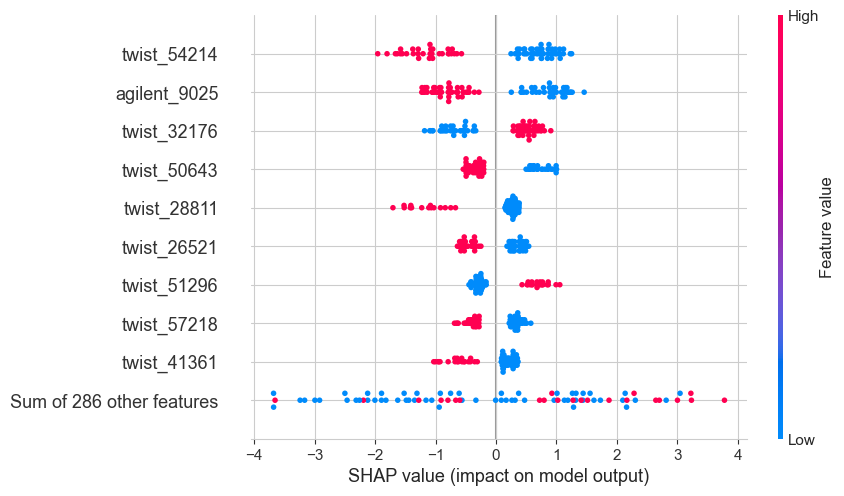

In [19]:
subgroup_name = "is_infect"
threshold = 5
df = subgroup_dfs[subgroup_name]

x, y = split_xy_df_and_filter_by_threshold(df.copy(), bottom_threshold=threshold / 100)

model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
model.fit(x, y)

explainer = shap.TreeExplainer(model, x)
shap_values = explainer(x)
shap.plots.beeswarm(shap_values, max_display=10, show=True)


In [20]:
shap_df = pd.DataFrame(shap_values.values, columns=x.columns)
mean_shap = shap_df.abs().mean().to_frame(name='SHAP value')

df_with_labels = x.copy()

df_with_labels['disease'] = y.values
df_with_labels['disease'] = y.map({0: 'Ctrl.', 1: 'Dis.'})

grouped = df_with_labels.groupby('disease').mean().T * 100
grouped = grouped[['Dis.', 'Ctrl.']]

grouped['Ratio (log)'] = np.log10((grouped['Dis.'] + 1) / (grouped['Ctrl.'] + 1))

summary_df = (
    mean_shap
    .join(grouped)
    .sort_values('SHAP value', ascending=False)
)
summary_df.index.name = 'peptide_name'
summary_df.reset_index(inplace=True)

summary_df['Full Name'] = peptide_info.loc[summary_df['peptide_name'], 'full name'].values
summary_df['Description'] = peptide_info.loc[summary_df['peptide_name'], 'Description'].values
summary_df['Family'] = peptide_info.loc[summary_df['peptide_name'], 'family'].values

cols_order = ['peptide_name', 'Full Name', 'Description', 'Family', 'SHAP value', 'Dis.', 'Ctrl.', 'Ratio (log)']
summary_df = summary_df[cols_order]

In [21]:
summary_df.head(10)

,peptide_name,Full Name,Description,Family,SHAP value,Dis.,Ctrl.,Ratio (log)
0,twist_54214,NaN,polyprotein,Picornaviridae,0.902733,22.5,55.0,-0.377120
1,agilent_9025,pneumococcal histidine triad protein E & hydro...,Bvh-3,Streptococcaceae,0.853753,37.5,67.5,-0.250230
2,twist_32176,NaN,Epstein-Barr nuclear antigen 1,Orthoherpesviridae,0.611969,65.0,50.0,0.111974
3,twist_50643,NaN,phosphoprotein 150,Orthoherpesviridae,0.464925,65.0,72.5,-0.046743
4,twist_28811,NaN,polyprotein,Picornaviridae,0.441457,7.5,30.0,-0.561943
5,twist_26521,NaN,EBNA3C latent protein,Orthoherpesviridae,0.412238,40.0,47.5,-0.072958
6,twist_51296,NaN,EBNA3C latent protein,Orthoherpesviridae,0.406794,40.0,17.5,0.345612
7,twist_57218,NaN,polyprotein,Picornaviridae,0.377909,35.0,57.5,-0.210853
8,twist_41361,NaN,phiRv1 phage protein,Mycobacteriaceae,0.326045,12.5,37.5,-0.455127
9,agilent_381,Bifunctional autolysin precursor,Bifunctional autolysin,Staphylococcaceae,0.319730,35.0,22.5,0.185235


#### Mejor resultado

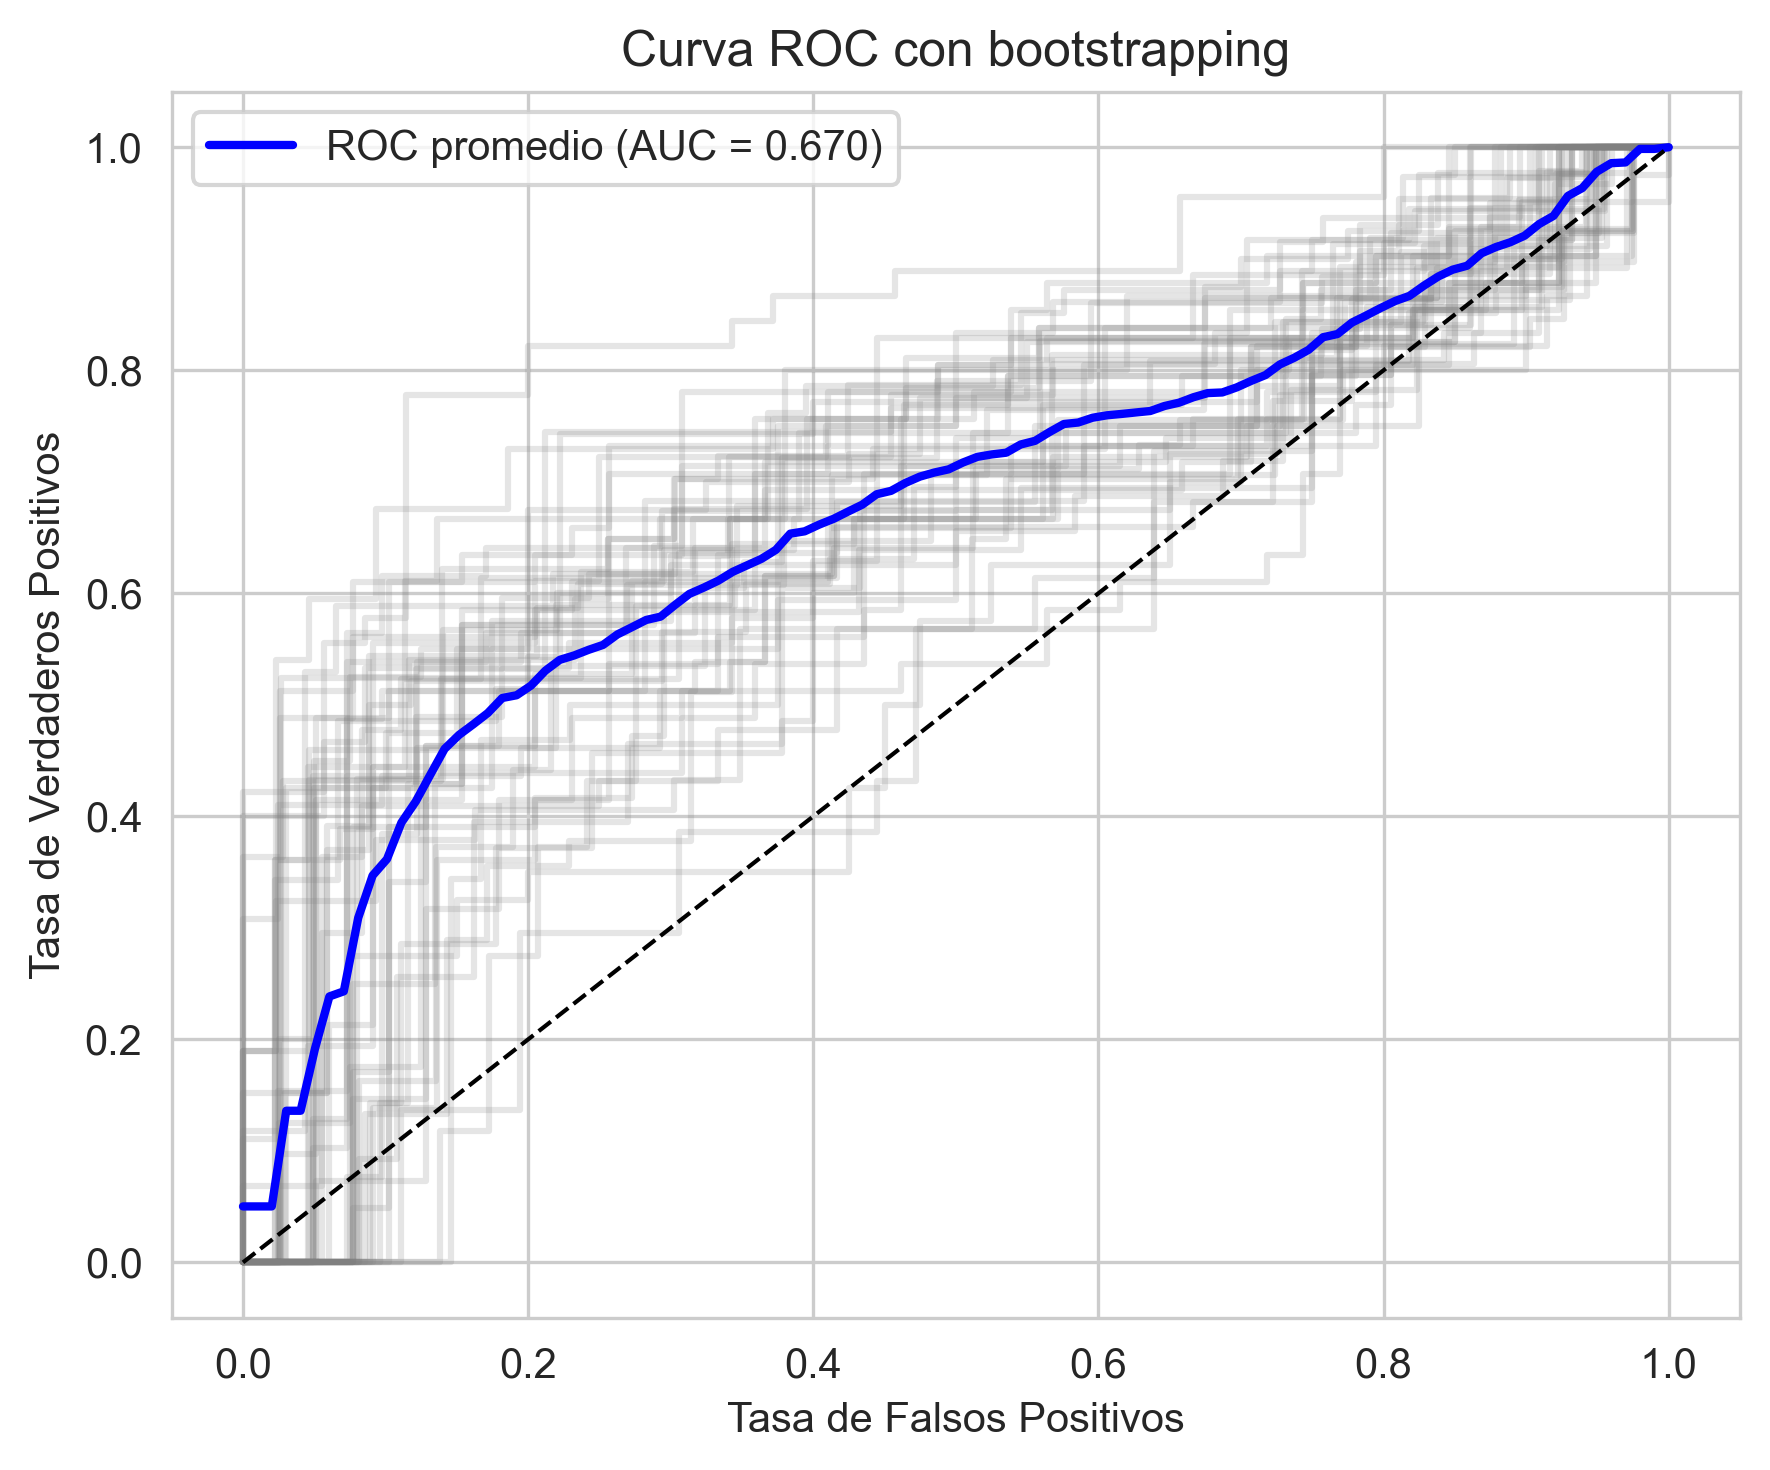

In [57]:
threshold = 5
df = subgroup_dfs['is_infect']
x, y = split_xy_df_and_filter_by_threshold(df.copy(), bottom_threshold=threshold / 100)

model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
df_preds = get_cross_validation_predictions(x, y, model)

y_true = df_preds['true_label'].values
y_score = df_preds['proba'].values

rng = np.random.default_rng(42)
n_bootstraps = 50
fpr_list, tpr_list = [], []
roc_auc_list = []

for _ in range(n_bootstraps):
    indices = rng.integers(0, len(y_true), size=len(y_true))
    y_true_sample = y_true[indices]
    y_score_sample = y_score[indices]

    try:
        fpr, tpr, _ = roc_curve(y_true_sample, y_score_sample)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        roc_auc_list.append(auc(fpr, tpr))
    except ValueError:
        continue

# Interpolación para curva promedio
fpr_base = np.linspace(0, 1, 100)
tpr_interp = [np.interp(fpr_base, f, t) for f, t in zip(fpr_list, tpr_list)]
tpr_mean = np.mean(tpr_interp, axis=0)

# Gráfico ROC
plt.figure(figsize=(6, 5), dpi=300)

for fpr, tpr in zip(fpr_list, tpr_list):
    plt.plot(fpr, tpr, color='gray', alpha=0.2)

plt.plot(fpr_base, tpr_mean, color='blue', lw=2, label=f"ROC promedio (AUC = {np.mean(roc_auc_list):.3f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title("Curva ROC con bootstrapping")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.legend()
plt.tight_layout()
plt.show()

In [58]:
rng = np.random.default_rng(42)
n_bootstraps = 50
youden_thresholds = []

for _ in range(n_bootstraps):
    indices = rng.integers(0, len(y_true), size=len(y_true))
    yt = y_true[indices]
    yp = y_score[indices]

    try:
        fpr, tpr, thresholds = roc_curve(yt, yp)
        j_scores = tpr - fpr
        best_idx = np.argmax(j_scores)
        best_threshold = thresholds[best_idx]
        youden_thresholds.append(best_threshold)
    except ValueError:
        continue

mean_thresh = np.mean(youden_thresholds)
std_thresh = np.std(youden_thresholds)

print(f"Promedio: {mean_thresh:.3f}")
print(f"Desviación estándar: {std_thresh:.3f}")


Promedio: 0.708
Desviación estándar: 0.145


In [59]:
from sklearn.metrics import precision_score, recall_score, f1_score

boot_precision = []
boot_recall = []
boot_f1 = []

threshold = mean_thresh

for _ in range(50):
    indices = rng.integers(0, len(y_true), size=len(y_true))
    yt = y_true[indices]
    yp = y_score[indices]
    
    y_pred = (yp > threshold).astype(int)
    
    try:
        boot_precision.append(precision_score(yt, y_pred, zero_division=0))
        boot_recall.append(recall_score(yt, y_pred, zero_division=0))
        boot_f1.append(f1_score(yt, y_pred, zero_division=0))
    except ValueError:
        continue

In [60]:
print(f"Precision (media ± SD): {np.mean(boot_precision):.3f} ± {np.std(boot_precision):.3f}")
print(f"Recall    (media ± SD): {np.mean(boot_recall):.3f} ± {np.std(boot_recall):.3f}")
print(f"F1-score  (media ± SD): {np.mean(boot_f1):.3f} ± {np.std(boot_f1):.3f}")


Precision (media ± SD): 0.711 ± 0.083
Recall    (media ± SD): 0.495 ± 0.071
F1-score  (media ± SD): 0.580 ± 0.066


#### Otras Features Metadata

In [22]:
metadata['appendectomy'] = metadata['appendectomy'].map({'Yes': 1, 'No': 0})

smoking_dummies = pd.get_dummies(metadata['smoking'], prefix='smoking')
metadata = pd.concat([metadata, smoking_dummies], axis=1)

metadata['smoking_Current_smoker'] = metadata['smoking_Current_smoker'].astype(int)
metadata['smoking_Ex_smoker'] = metadata['smoking_Ex_smoker'].astype(int)
metadata['smoking_Never'] = metadata['smoking_Never'].astype(int)

metadata['sex_binary'] = metadata['sex'].map({'Female': 1, 'Male': 0})

In [25]:
configs = {
    'only_peptides': [],
    'smoking_and_appendectomy': ['smoking_Current_smoker', 'smoking_Ex_smoker', 'smoking_Never', 'appendectomy'],
    'age_sex': ['age', 'sex_binary'],
    'all': ['age', 'sex_binary', 'smoking_Current_smoker', 'smoking_Ex_smoker', 'smoking_Never', 'appendectomy'],
    'only_smoking': ['smoking_Current_smoker', 'smoking_Ex_smoker', 'smoking_Never'],
    'smoking_only_no_peptides': ['smoking_Current_smoker', 'smoking_Ex_smoker', 'smoking_Never']
}


all_auc_results = []
bootstrap_auc_records = []
rng = np.random.default_rng(42)

is_infect_df = subgroup_dfs['is_infect']
subgroup_name = 'is_infect'  # fijo

for config_name, config_vars in configs.items():

    if config_name == 'smoking_only_no_peptides':

        df = metadata[config_vars + ['disease']].copy()
    else:
        df = add_clinical_variables(is_infect_df, metadata, config_vars)

    xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
    preds = get_predictions_for_all_thresholds(xgb_model, df)

    for threshold, group_df in preds.groupby(level='threshold_percent'):
        if group_df.empty:
            print(f'Sin datos para threshold {threshold}, se omite.')
            continue

        aucs = []

        for i in range(50):

            unique_string = f"{subgroup_name}-{config_name}-{threshold}-{i}"
            seed_hash = int(hashlib.sha256(unique_string.encode('utf-8')).hexdigest(), 16)
            seed = seed_hash % (2**32 - 1)

            sample = group_df.sample(n=len(group_df), replace=True, random_state=rng)

            try:
                auc_val = roc_auc_score(sample['true_label'], sample['proba'])
                aucs.append(auc_val)

                bootstrap_auc_records.append({
                    'subgroup': subgroup_name,
                    'config': config_name,
                    'threshold_percent': threshold,
                    'auc': auc_val
                })

            except ValueError:
                continue

        if aucs:
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)
            num_peptides = group_df['num_peptides'].iloc[0] if 'num_peptides' in group_df else 0

            all_auc_results.append({
                'subgroup': subgroup_name,
                'config': config_name,
                'threshold_percent': threshold,
                'mean_auc': mean_auc,
                'std_auc': std_auc,
                'num_peptides': num_peptides
            })

auc_summary_df_best_subgroup_exist_bias = pd.DataFrame(all_auc_results)
bootstrap_auc_df_best_subgroup_exist_bias = pd.DataFrame(bootstrap_auc_records)


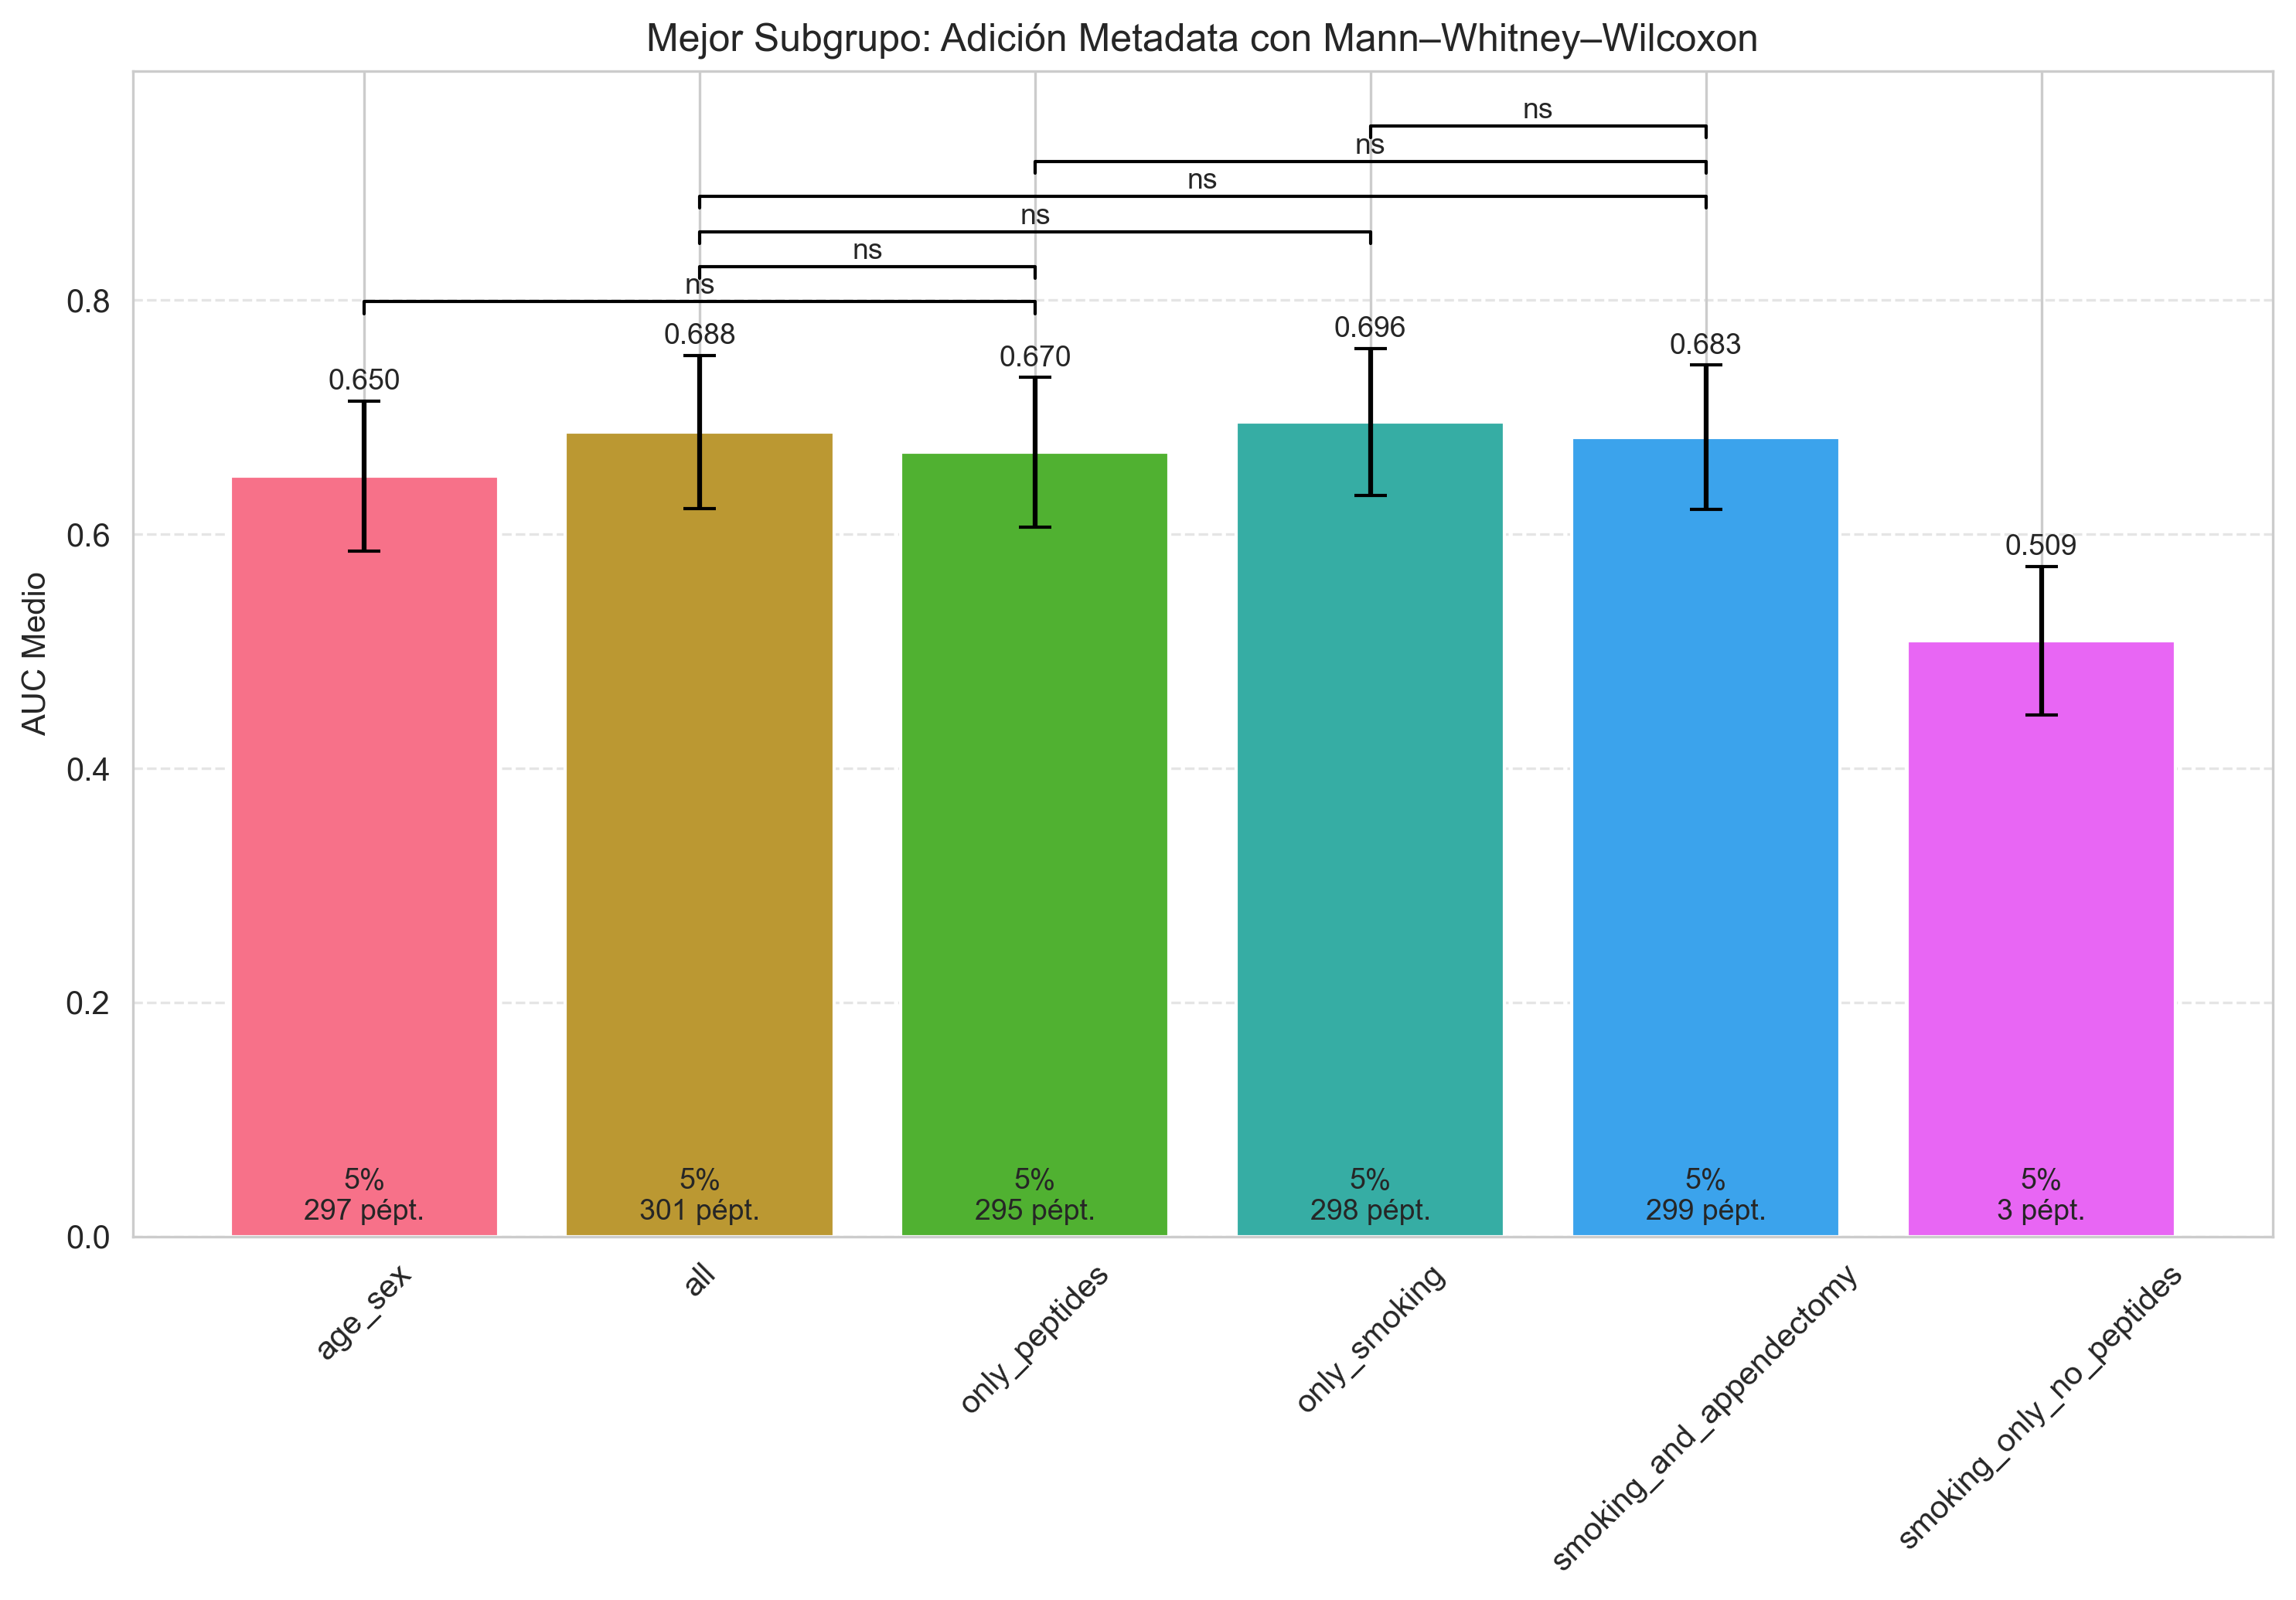

In [26]:
best_auc_df = auc_summary_df_best_subgroup_exist_bias.loc[
    auc_summary_df_best_subgroup_exist_bias.groupby('config')['mean_auc'].idxmax()
]

filtered_bootstrap_df = pd.merge(
    bootstrap_auc_df_best_subgroup_exist_bias,
    best_auc_df[['config', 'threshold_percent']],
    on=['config', 'threshold_percent']
)

summary_df = filtered_bootstrap_df.groupby('config')['auc'].agg(['mean', 'std']).reset_index()
summary_df = pd.merge(summary_df, best_auc_df[['config', 'threshold_percent', 'num_peptides']], on='config')

pairwise_results = {}
configs = summary_df['config'].tolist()

for g1, g2 in itertools.combinations(configs, 2):
    aucs_g1 = filtered_bootstrap_df.loc[filtered_bootstrap_df['config'] == g1, 'auc']
    aucs_g2 = filtered_bootstrap_df.loc[filtered_bootstrap_df['config'] == g2, 'auc']
    stat, p = mannwhitneyu(aucs_g1, aucs_g2, alternative='two-sided')
    pairwise_results[(g1, g2)] = p

plt.figure(figsize=(10, 7), dpi=300)
sns.set_style("whitegrid")

bars = plt.bar(
    summary_df['config'],
    summary_df['mean'],
    yerr=summary_df['std'],
    capsize=5,
    color=sns.color_palette("husl", len(summary_df))
)

for bar, mean, std, threshold, n_pep in zip(
    bars,
    summary_df['mean'],
    summary_df['std'],
    summary_df['threshold_percent'],
    summary_df['num_peptides']
):
    
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        mean + std + 0.005,
        f"{mean:.3f}",
        ha='center',
        va='bottom',
        fontsize=9
    )

    label = f'{threshold}%\n{n_pep} pépt.'
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        0.01,
        label,
        ha='center',
        va='bottom',
        fontsize=9
    )

y_max = (summary_df['mean'] + summary_df['std']).max()
step = 0.03
y_pos = y_max + 0.03

for (g1, g2), p in pairwise_results.items():
    if p > 0.05:
        i = summary_df.index[summary_df['config'] == g1][0]
        j = summary_df.index[summary_df['config'] == g2][0]
        x1, x2 = min(i, j), max(i, j)
        plt.plot([x1, x1, x2, x2], [y_pos, y_pos + 0.01, y_pos + 0.01, y_pos], lw=1, c='black')
        plt.text((x1 + x2) / 2, y_pos + 0.012, 'ns', ha='center', va='bottom', fontsize=9)
        y_pos += step

plt.ylabel('AUC Medio')
plt.title('Mejor Subgrupo: Adición Metadata con Mann–Whitney–Wilcoxon')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

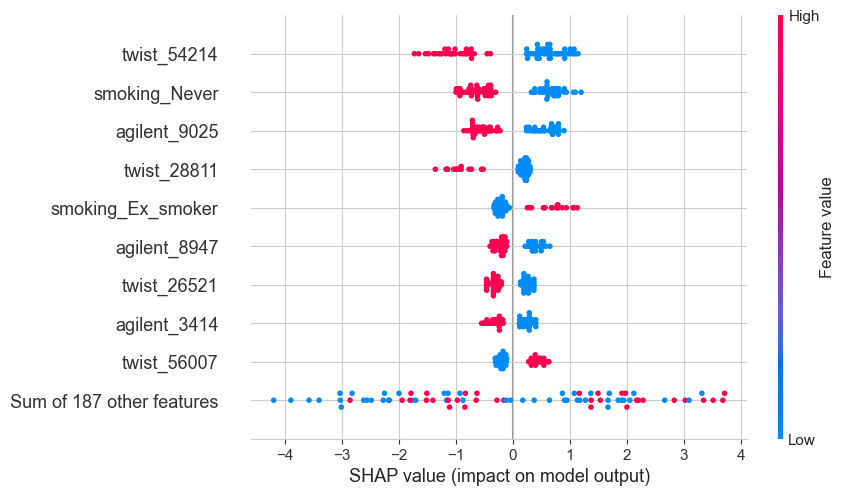

In [27]:
df = add_clinical_variables(is_infect_df, metadata, ['smoking_Current_smoker', 'smoking_Ex_smoker', 'smoking_Never'])

x, y = split_xy_df_and_filter_by_threshold(df.copy(), bottom_threshold= 10/ 100)

model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
model.fit(x, y)

explainer = shap.TreeExplainer(model, x)
shap_values = explainer(x)
shap.plots.beeswarm(shap_values, max_display=10, show=True)


In [28]:
shap_df = pd.DataFrame(shap_values.values, columns=x.columns)
mean_shap = shap_df.abs().mean().to_frame(name='SHAP value')

df_with_labels = x.copy()
df_with_labels['disease'] = y.values
df_with_labels['disease'] = y.map({0: 'Ctrl.', 1: 'Dis.'})

grouped = df_with_labels.groupby('disease').mean().T * 100
grouped = grouped[['Dis.', 'Ctrl.']]
grouped['Ratio (log)'] = np.log10((grouped['Dis.'] + 1) / (grouped['Ctrl.'] + 1))

summary_df = (
    mean_shap
    .join(grouped)
    .sort_values('SHAP value', ascending=False)
)
summary_df.index.name = 'peptide_name'
summary_df.reset_index(inplace=True)

summary_df['Full Name'] = summary_df['peptide_name'].map(peptide_info['full name'].to_dict())
summary_df['Description'] = summary_df['peptide_name'].map(peptide_info['Description'].to_dict())
summary_df['Family'] = summary_df['peptide_name'].map(peptide_info['family'].to_dict())

cols_order = ['peptide_name', 'Full Name', 'Description', 'Family', 'SHAP value', 'Dis.', 'Ctrl.', 'Ratio (log)']
summary_df = summary_df[cols_order]


In [29]:
summary_df.head(10)

,peptide_name,Full Name,Description,Family,SHAP value,Dis.,Ctrl.,Ratio (log)
0,twist_54214,NaN,polyprotein,Picornaviridae,0.805563,22.5,55.0,-0.377120
1,smoking_Never,NaN,NaN,NaN,0.660652,37.5,67.5,-0.250230
2,agilent_9025,pneumococcal histidine triad protein E & hydro...,Bvh-3,Streptococcaceae,0.561420,37.5,67.5,-0.250230
3,twist_28811,NaN,polyprotein,Picornaviridae,0.353093,7.5,30.0,-0.561943
4,smoking_Ex_smoker,NaN,NaN,NaN,0.323629,35.0,10.0,0.514910
5,agilent_8947,phosphoprotein 150 & Large structural phosphop...,Large structural phosphoprotein,Orthoherpesviridae,0.284219,62.5,67.5,-0.032917
6,twist_26521,NaN,EBNA3C latent protein,Orthoherpesviridae,0.281227,40.0,47.5,-0.072958
7,agilent_3414,pneumococcal histidine triad protein E & hydro...,Bvh-3,Streptococcaceae,0.274932,35.0,55.0,-0.191886
8,twist_56007,NaN,phosphoprotein 150,Orthoherpesviridae,0.274704,42.5,17.5,0.371318
9,agilent_3616,choline-binding protein D,Autolysin,Streptococcaceae,0.261122,42.5,40.0,0.025705


### Fold data

In [44]:
cols_with_inf = fold_data.columns[np.isinf(fold_data).any()]
df_clean = fold_data.drop(columns=cols_with_inf)

df_log = np.log1p(df_clean)

In [45]:
subgroup_dfs = {}

full_df = df_log.copy()
full_df['disease'] = metadata['disease'].values
subgroup_dfs['all'] = full_df

for subgroup in peptide_info.columns:

    full_df = df_log.copy()
    valid_cols = get_peptides_in_subgroup(full_df, peptide_info, subgroup)

    if len(valid_cols) == 0:
        continue

    subset_df = df_log[valid_cols].copy()
    subset_df['disease'] = metadata['disease'].values
    subgroup_dfs[subgroup] = subset_df

In [46]:
rng = np.random.default_rng(42)
all_auc_results_3 = []
bootstrap_auc_records = []

for subgroup_name, df in subgroup_dfs.items():
    xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
    preds = get_predictions_for_all_thresholds(xgb_model, df)

    for threshold, group_df in preds.groupby(level='threshold_percent'):

        if group_df.empty:
            print(f"Sin datos para threshold {threshold}, se omite.")
            continue

        aucs = []
        for _ in range(50): 

            sample = group_df.sample(n=len(group_df), replace=True, random_state=rng)

            try:
                auc_val = roc_auc_score(sample['true_label'], sample['proba'])
                aucs.append(auc_val)

                bootstrap_auc_records.append({
                    'subgroup': subgroup_name,
                    'threshold_percent': threshold,
                    'auc': auc_val
                })
                
                
            except ValueError:
                continue

        if aucs:
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)

            num_peptides = group_df['num_peptides'].iloc[0]

            all_auc_results_3.append({
                'subgroup': subgroup_name,
                'threshold_percent': threshold,
                'mean_auc': mean_auc,
                'std_auc': std_auc,
                'num_peptides': num_peptides
            })

auc_summary_df_all_subgroups_fold = pd.DataFrame(all_auc_results_3)
bootstrap_auc_df_all_subgroups_fold = pd.DataFrame(bootstrap_auc_records)

No queda ningúna columna tras usar threshold 30
No queda ningúna columna tras usar threshold 30
No queda ningúna columna tras usar threshold 30


#### Gráficos

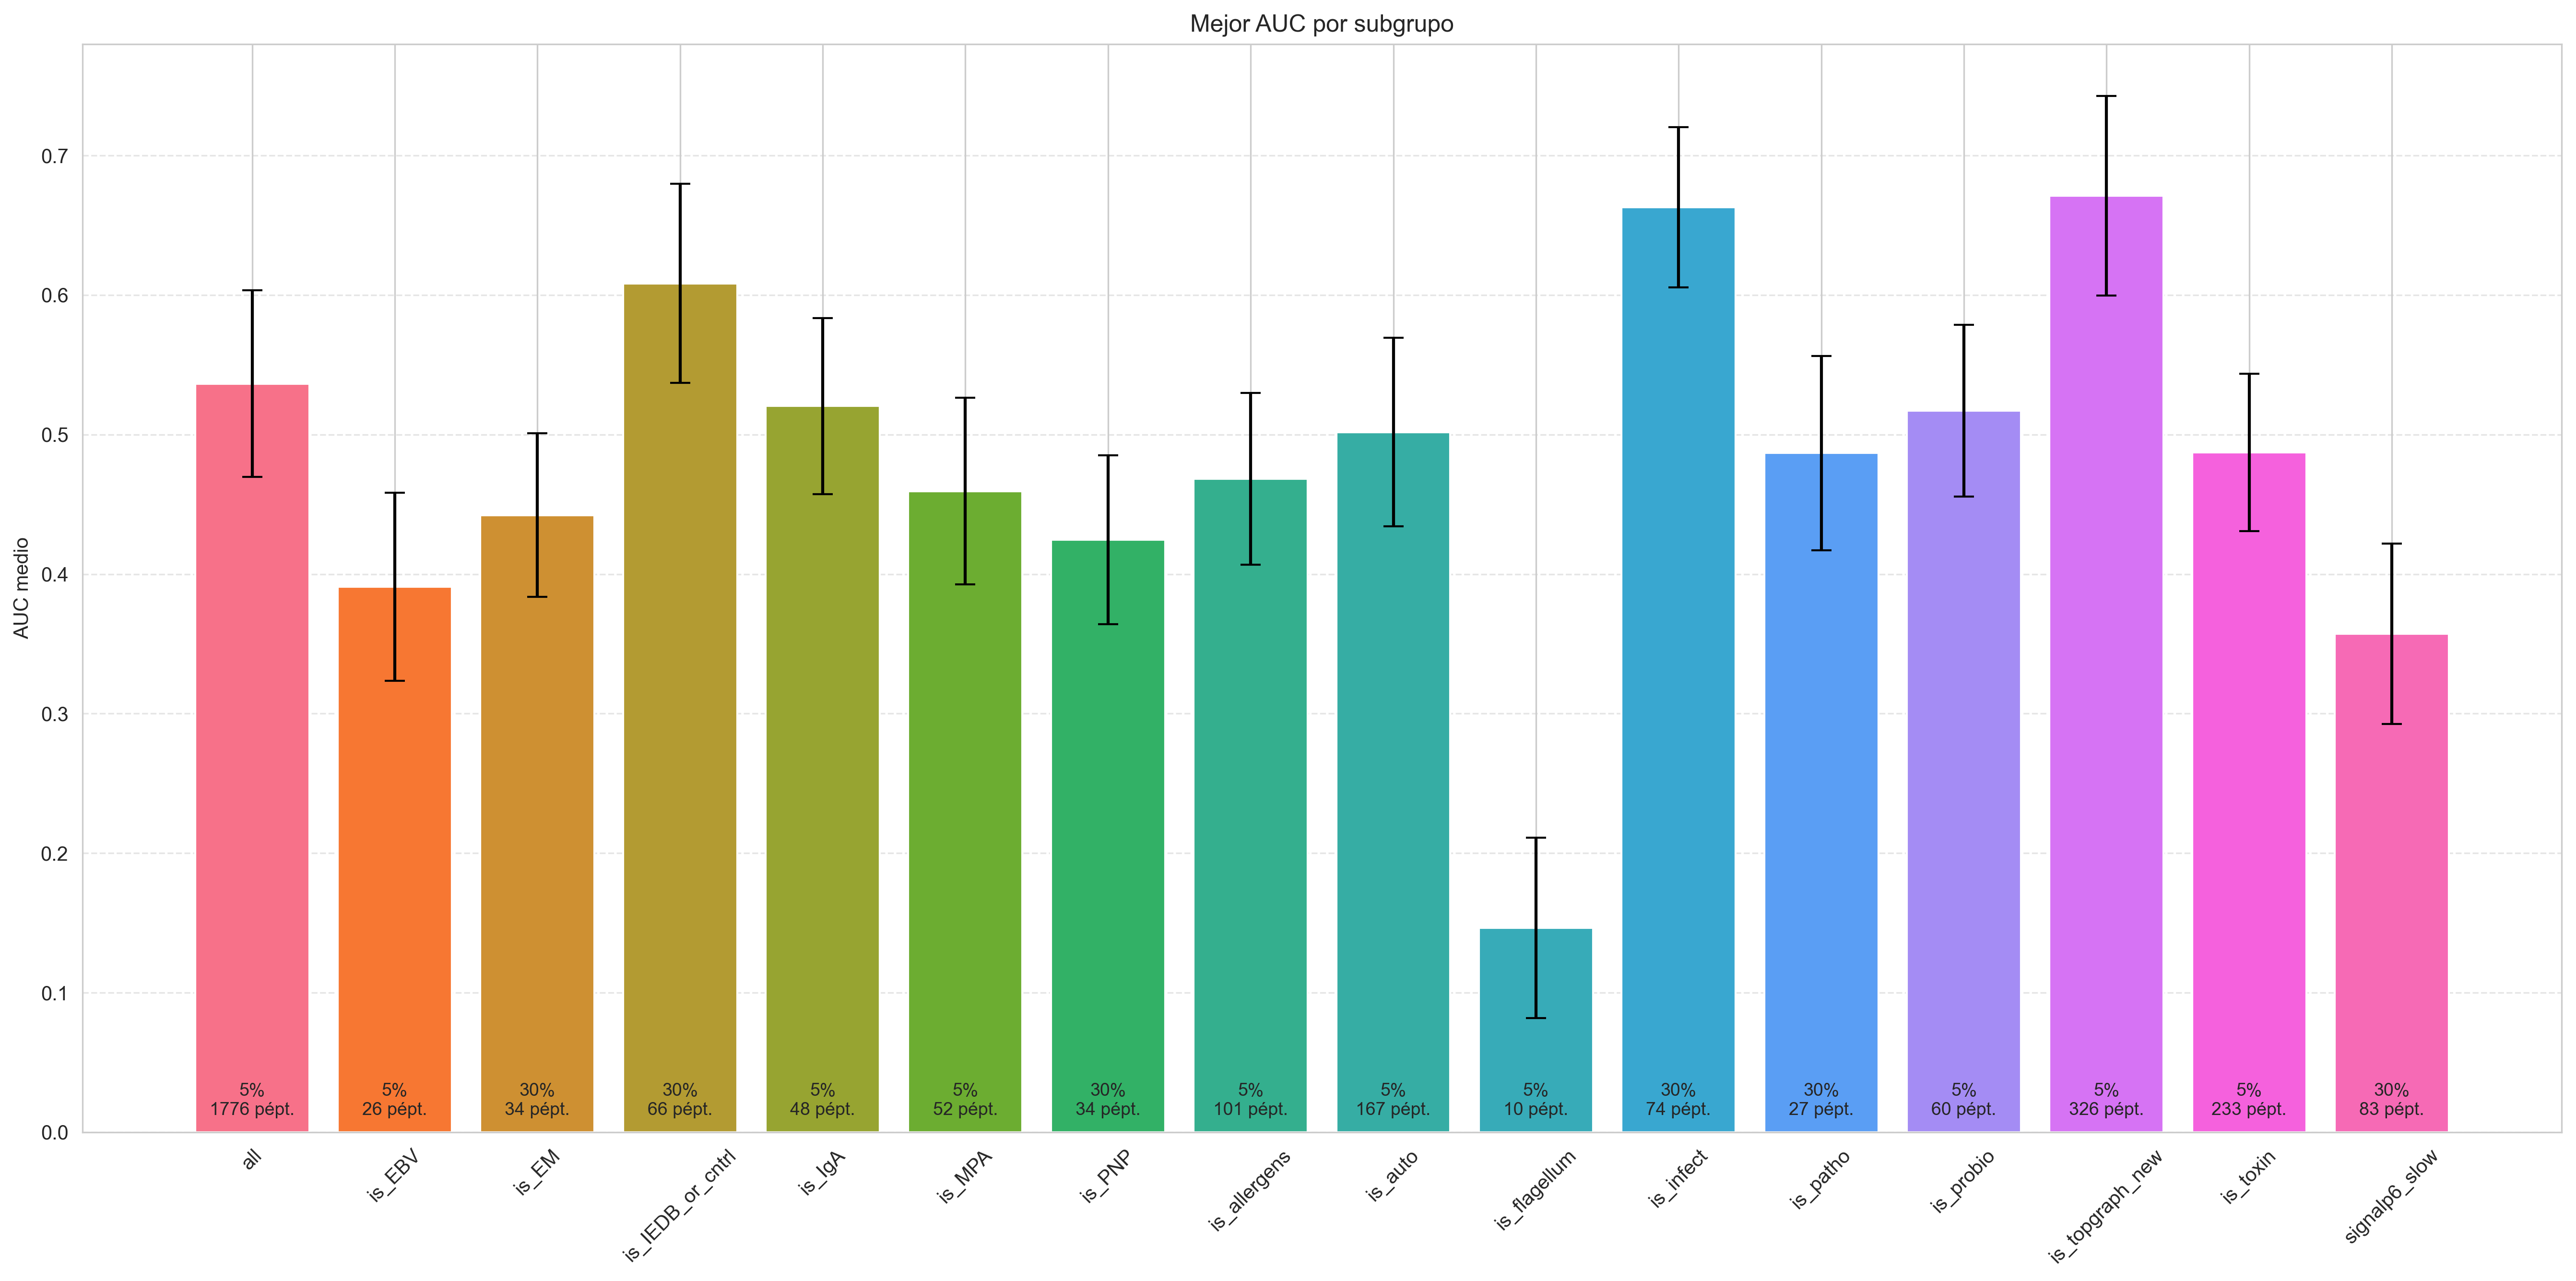

In [47]:
best_auc_df = auc_summary_df_all_subgroups_fold.loc[auc_summary_df_all_subgroups_fold.groupby('subgroup')['mean_auc'].idxmax()]

n = len(best_auc_df)

plt.figure(figsize=(18, 9), dpi=300)
bars = plt.bar(
    best_auc_df['subgroup'], 
    best_auc_df['mean_auc'], 
    yerr=best_auc_df['std_auc'], 
    capsize=5,
    color=sns.color_palette("husl", n_colors=n),
)

for bar, threshold, n_pep in zip(bars, best_auc_df['threshold_percent'], best_auc_df['num_peptides']):
    height = bar.get_height()
    label = f'{threshold}%\n{n_pep} pépt.'
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        0.01, 
        label, 
        ha='center', 
        va='bottom', 
        fontsize=9
    )

plt.ylabel('AUC medio')
plt.title('Mejor AUC por subgrupo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

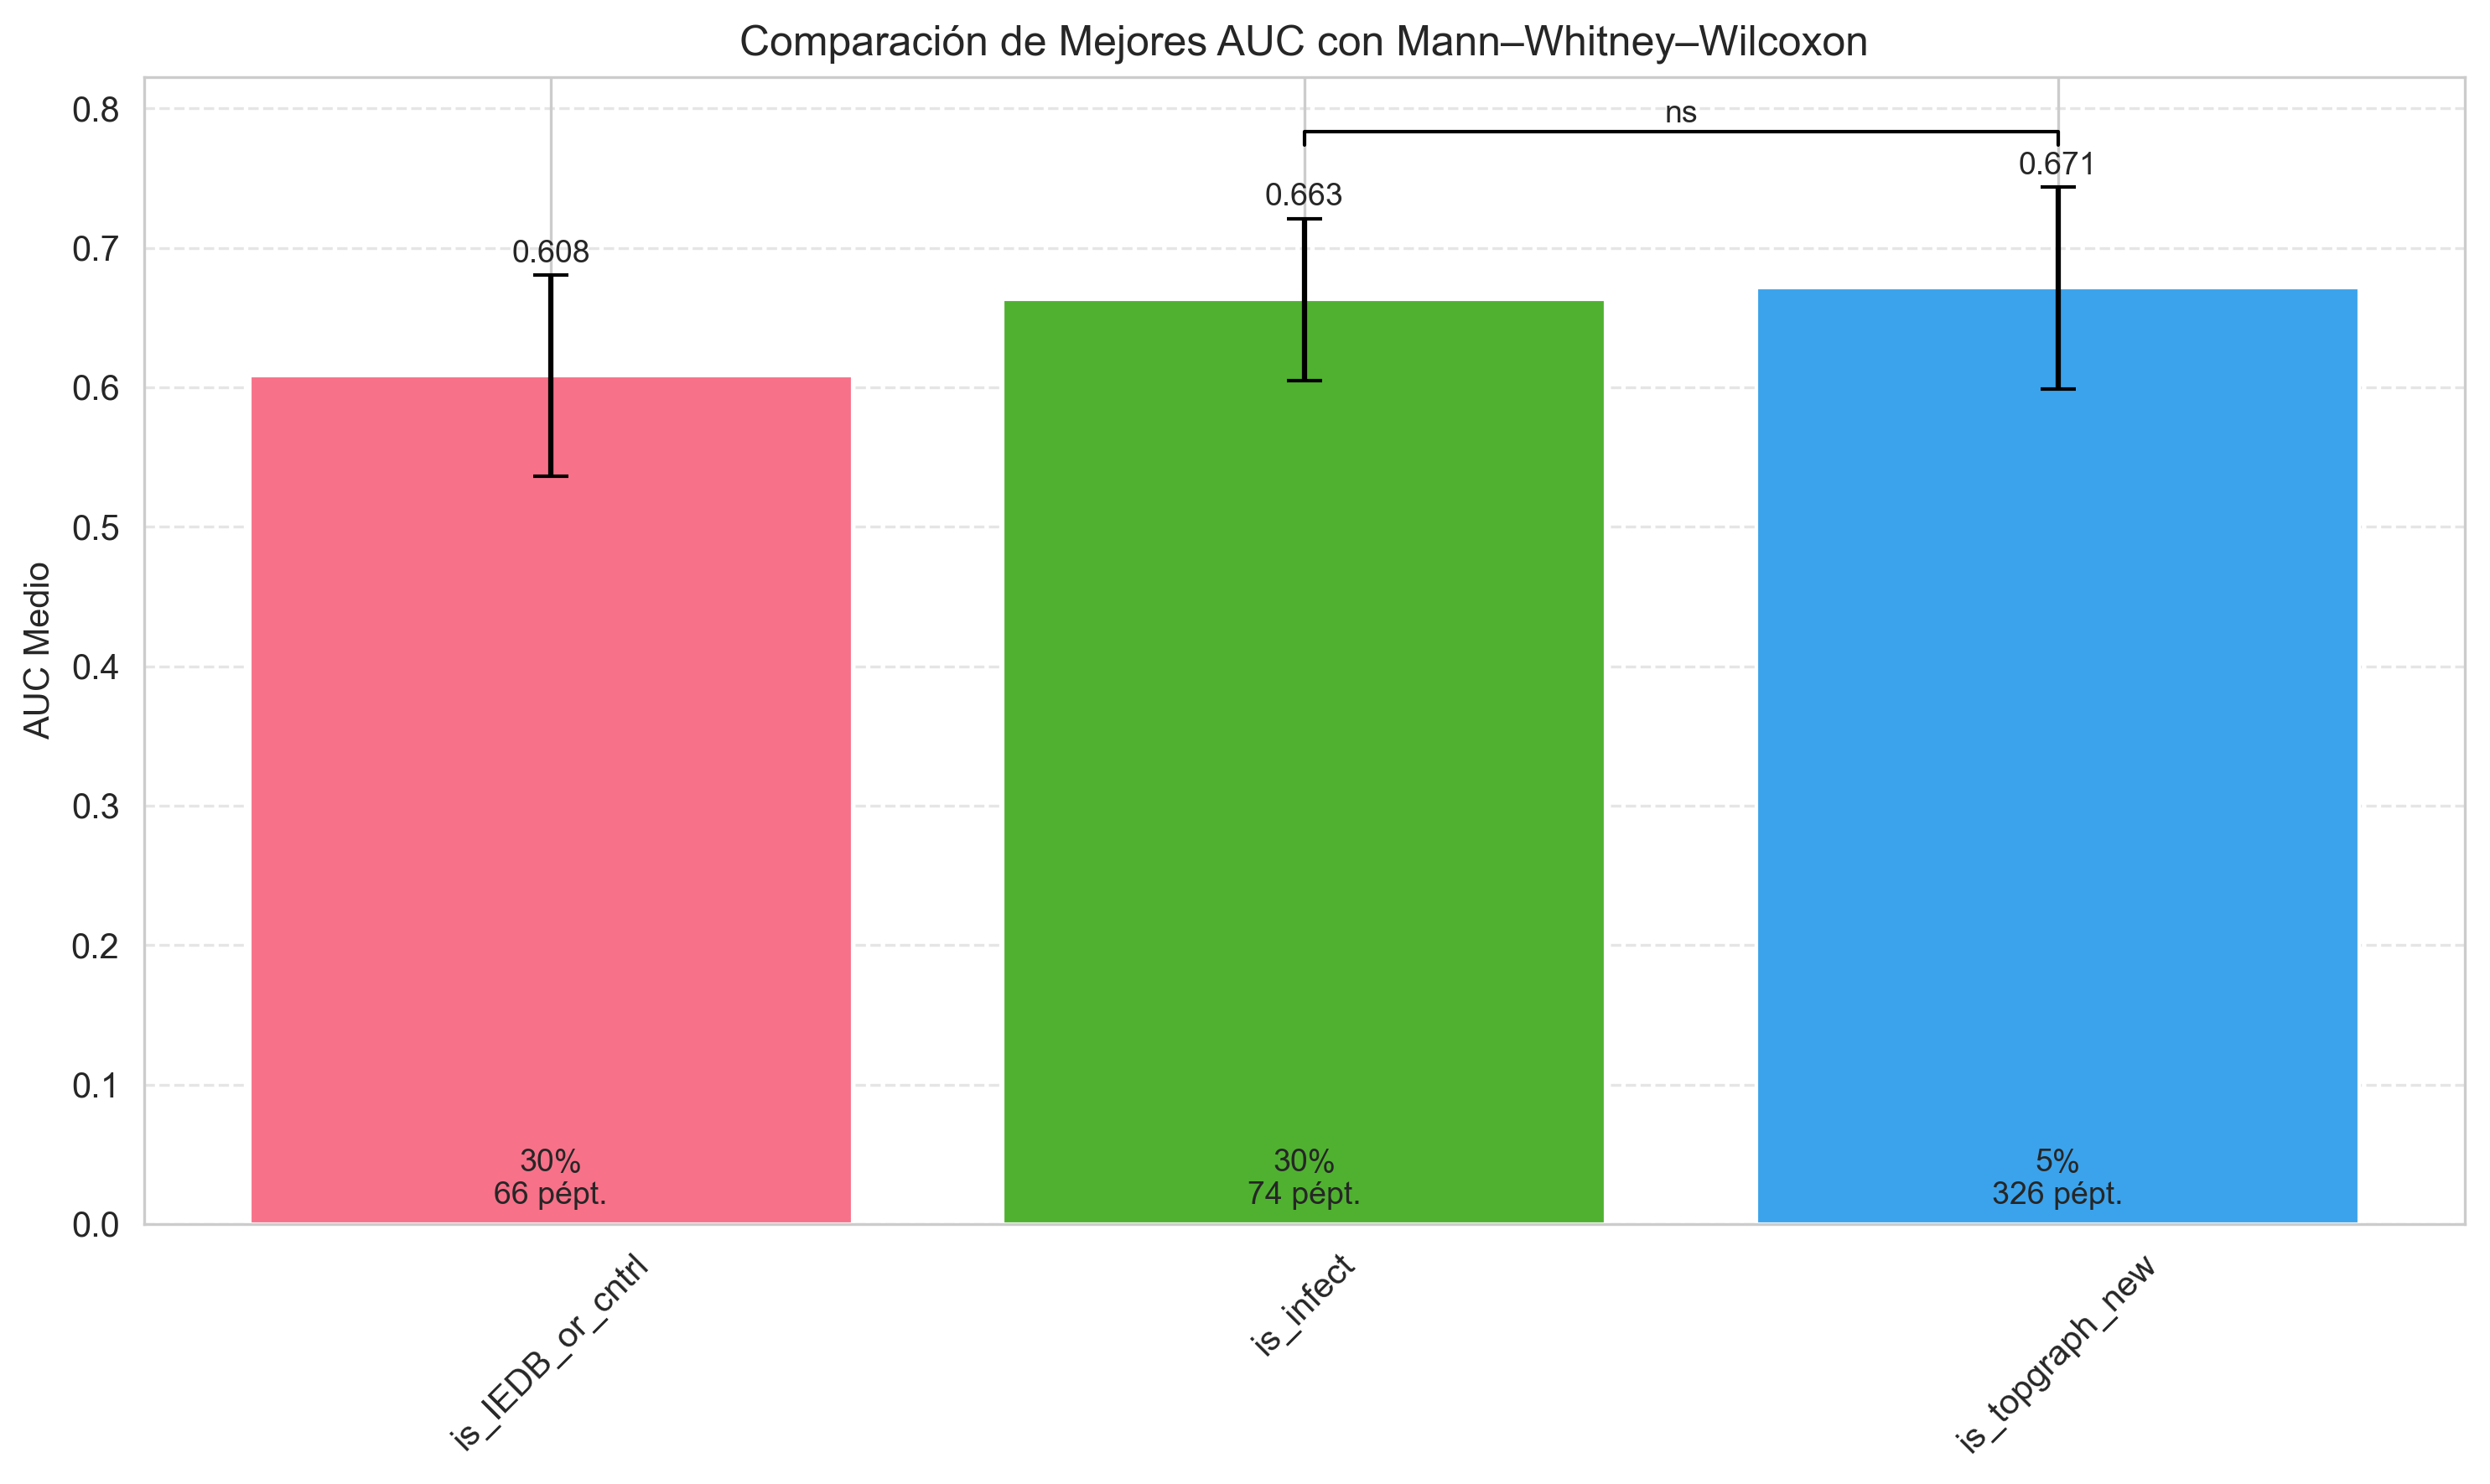

In [48]:
best_auc_df = auc_summary_df_all_subgroups_fold.loc[auc_summary_df_all_subgroups_fold.groupby('subgroup')['mean_auc'].idxmax()]
best_auc_df = best_auc_df[best_auc_df['mean_auc'] > 0.6]

filtered_bootstrap_df = pd.merge(
    bootstrap_auc_df_all_subgroups_fold,
    best_auc_df[['subgroup', 'threshold_percent']],
    on=['subgroup', 'threshold_percent']
)

summary_df = filtered_bootstrap_df.groupby('subgroup')['auc'].agg(['mean', 'std']).reset_index()

summary_df = pd.merge(summary_df, best_auc_df[['subgroup', 'threshold_percent', 'num_peptides']], on='subgroup')

pairwise_results = {}
subgroups = summary_df['subgroup'].tolist()

for g1, g2 in itertools.combinations(subgroups, 2):
    aucs_g1 = filtered_bootstrap_df.loc[filtered_bootstrap_df['subgroup'] == g1, 'auc']
    aucs_g2 = filtered_bootstrap_df.loc[filtered_bootstrap_df['subgroup'] == g2, 'auc']
    stat, p = mannwhitneyu(aucs_g1, aucs_g2, alternative='two-sided')
    pairwise_results[(g1, g2)] = p

plt.figure(figsize=(10, 6), dpi=300)
sns.set_style("whitegrid")

bars = plt.bar(
    summary_df['subgroup'],
    summary_df['mean'],
    yerr=summary_df['std'],
    capsize=5,
    color=sns.color_palette("husl", len(summary_df))
)

for bar, mean, std, threshold, n_pep in zip(
    bars,
    summary_df['mean'],
    summary_df['std'],
    summary_df['threshold_percent'],
    summary_df['num_peptides']
):
    # Etiqueta superior
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        mean + std + 0.005,
        f"{mean:.3f}",
        ha='center',
        va='bottom',
        fontsize=9
    )
    # Etiqueta inferior
    label = f'{threshold}%\n{n_pep} pépt.'
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        0.01,
        label,
        ha='center',
        va='bottom',
        fontsize=9
    )

y_max = (summary_df['mean'] + summary_df['std']).max()
step = 0.05
y_pos = y_max + 0.03

for (g1, g2), p in pairwise_results.items():
    if p > 0.05:
        i = summary_df.index[summary_df['subgroup'] == g1][0]
        j = summary_df.index[summary_df['subgroup'] == g2][0]
        x1, x2 = min(i, j), max(i, j)
        plt.plot([x1, x1, x2, x2], [y_pos, y_pos + 0.01, y_pos + 0.01, y_pos], lw=1, c='black')
        plt.text((x1 + x2) / 2, y_pos + 0.012, 'ns', ha='center', va='bottom', fontsize=9)
        y_pos += step

plt.ylabel('AUC Medio')
plt.title('Comparación de Mejores AUC con Mann–Whitney–Wilcoxon')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



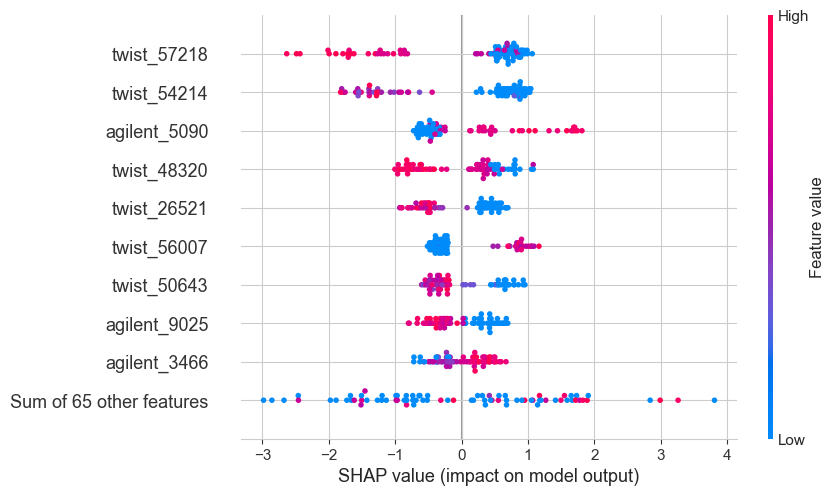

In [49]:
subgroup_name = "is_infect"
threshold = 30
df = subgroup_dfs[subgroup_name]

x, y = split_xy_df_and_filter_by_threshold(df.copy(), bottom_threshold=threshold / 100)

model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
model.fit(x, y)

explainer = shap.TreeExplainer(model, x)
shap_values = explainer(x)
shap.plots.beeswarm(shap_values, max_display=10, show=True)


In [51]:
shap_df = pd.DataFrame(shap_values.values, columns=x.columns)
mean_shap = shap_df.abs().mean().to_frame(name='SHAP value')

df_with_labels = x.copy()

df_with_labels['disease'] = y.values
df_with_labels['disease'] = y.map({0: 'Ctrl.', 1: 'Dis.'})

grouped = df_with_labels.groupby('disease').mean().T
grouped = grouped[['Dis.', 'Ctrl.']]

grouped['Ratio (log)'] = np.log10((grouped['Dis.'] + 1) / (grouped['Ctrl.'] + 1))

summary_df = (
    mean_shap
    .join(grouped)
    .sort_values('SHAP value', ascending=False)
)
summary_df.index.name = 'peptide_name'
summary_df.reset_index(inplace=True)

summary_df['Full Name'] = peptide_info.loc[summary_df['peptide_name'], 'full name'].values
summary_df['Description'] = peptide_info.loc[summary_df['peptide_name'], 'Description'].values
summary_df['Family'] = peptide_info.loc[summary_df['peptide_name'], 'family'].values

cols_order = ['peptide_name', 'Full Name', 'Description', 'Family', 'SHAP value', 'Dis.', 'Ctrl.', 'Ratio (log)']
summary_df = summary_df[cols_order]

In [52]:
summary_df.head(10)

,peptide_name,Full Name,Description,Family,SHAP value,Dis.,Ctrl.,Ratio (log)
0,twist_57218,NaN,polyprotein,Picornaviridae,0.944157,1.120374,2.110286,-0.166388
1,twist_54214,NaN,polyprotein,Picornaviridae,0.942315,0.435802,1.076902,-0.160321
2,agilent_5090,Capsid protein VP26 & capsid protein VP26 [Hum...,Small capsomere-interacting protein,Orthoherpesviridae,0.634452,3.124537,2.248091,0.103747
3,twist_48320,NaN,pneumococcal histidine triad protein D,Streptococcaceae,0.585335,2.529540,3.607970,-0.115792
4,twist_26521,NaN,EBNA3C latent protein,Orthoherpesviridae,0.490691,0.653812,0.788499,-0.034002
5,twist_56007,NaN,phosphoprotein 150,Orthoherpesviridae,0.476492,1.203210,0.468429,0.176203
6,twist_50643,NaN,phosphoprotein 150,Orthoherpesviridae,0.447194,2.141176,2.126828,0.001988
7,agilent_9025,pneumococcal histidine triad protein E & hydro...,Bvh-3,Streptococcaceae,0.381254,1.357858,2.439985,-0.164039
8,agilent_3466,Epstein-Barr nuclear antigen 1 & EBNA-1 protei...,Epstein-Barr nuclear antigen 1,Orthoherpesviridae,0.318094,3.603440,3.127045,0.047443
9,agilent_2403,phosphoprotein 150 & Large structural phosphop...,Large structural phosphoprotein,Orthoherpesviridae,0.314752,1.473899,0.651734,0.175442


In [53]:
configs = {
    'only_peptides': [],
    'smoking_and_appendectomy': ['smoking_Current_smoker', 'smoking_Ex_smoker', 'smoking_Never', 'appendectomy'],
    'age_sex': ['age', 'sex_binary'],
    'all': ['age', 'sex_binary', 'smoking_Current_smoker', 'smoking_Ex_smoker', 'smoking_Never', 'appendectomy'],
    'only_smoking': ['smoking_Current_smoker', 'smoking_Ex_smoker', 'smoking_Never'],
    'smoking_only_no_peptides': ['smoking_Current_smoker', 'smoking_Ex_smoker', 'smoking_Never']
}


all_auc_results = []
bootstrap_auc_records = []
rng = np.random.default_rng(42)

is_infect_df = subgroup_dfs['is_infect']
subgroup_name = 'is_infect'  # fijo

for config_name, config_vars in configs.items():

    if config_name == 'smoking_only_no_peptides':

        df = metadata[config_vars + ['disease']].copy()
    else:
        df = add_clinical_variables(is_infect_df, metadata, config_vars)

    xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
    preds = get_predictions_for_all_thresholds(xgb_model, df)

    for threshold, group_df in preds.groupby(level='threshold_percent'):
        if group_df.empty:
            print(f'Sin datos para threshold {threshold}, se omite.')
            continue

        aucs = []

        for i in range(50):

            unique_string = f"{subgroup_name}-{config_name}-{threshold}-{i}"
            seed_hash = int(hashlib.sha256(unique_string.encode('utf-8')).hexdigest(), 16)
            seed = seed_hash % (2**32 - 1)

            sample = group_df.sample(n=len(group_df), replace=True, random_state=rng)

            try:
                auc_val = roc_auc_score(sample['true_label'], sample['proba'])
                aucs.append(auc_val)

                bootstrap_auc_records.append({
                    'subgroup': subgroup_name,
                    'config': config_name,
                    'threshold_percent': threshold,
                    'auc': auc_val
                })

            except ValueError:
                continue

        if aucs:
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)
            num_peptides = group_df['num_peptides'].iloc[0] if 'num_peptides' in group_df else 0

            all_auc_results.append({
                'subgroup': subgroup_name,
                'config': config_name,
                'threshold_percent': threshold,
                'mean_auc': mean_auc,
                'std_auc': std_auc,
                'num_peptides': num_peptides
            })

auc_summary_df_best_subgroup_fold_bias = pd.DataFrame(all_auc_results)
bootstrap_auc_df_best_subgroup_fold_bias = pd.DataFrame(bootstrap_auc_records)


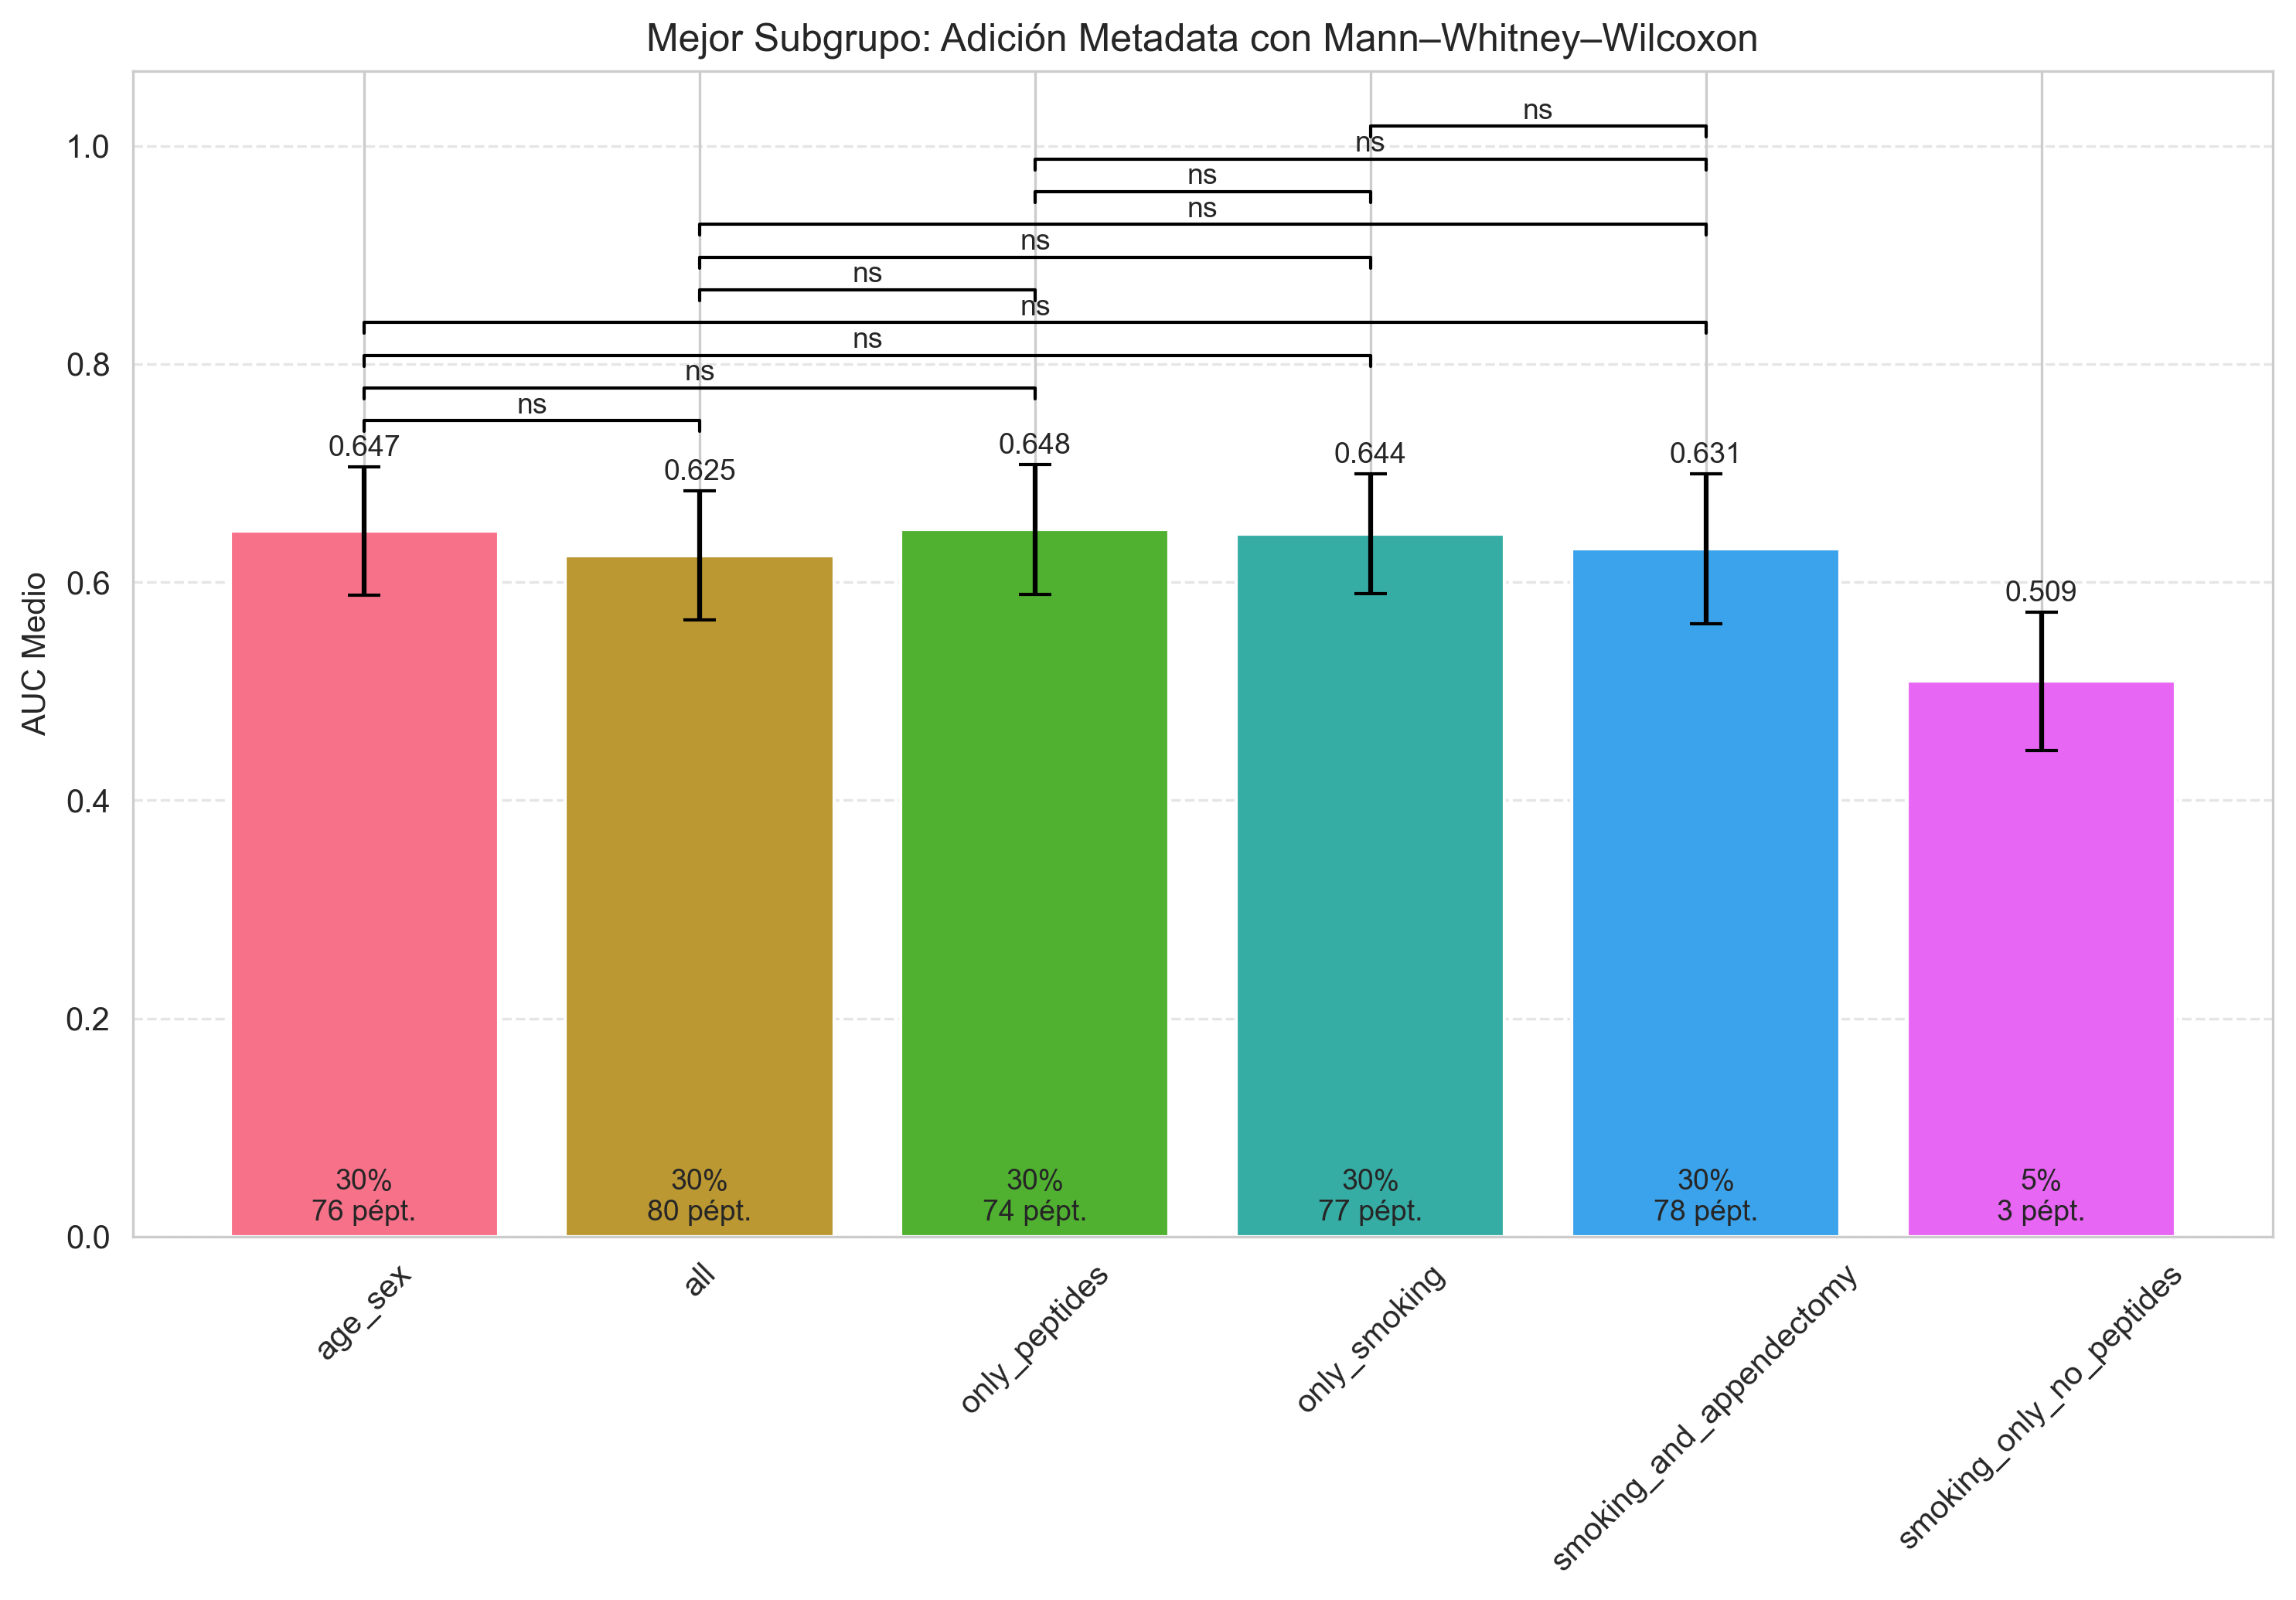

In [54]:
best_auc_df = auc_summary_df_best_subgroup_fold_bias.loc[
    auc_summary_df_best_subgroup_fold_bias.groupby('config')['mean_auc'].idxmax()
]

filtered_bootstrap_df = pd.merge(
    bootstrap_auc_df_best_subgroup_fold_bias,
    best_auc_df[['config', 'threshold_percent']],
    on=['config', 'threshold_percent']
)

summary_df = filtered_bootstrap_df.groupby('config')['auc'].agg(['mean', 'std']).reset_index()
summary_df = pd.merge(summary_df, best_auc_df[['config', 'threshold_percent', 'num_peptides']], on='config')

pairwise_results = {}
configs = summary_df['config'].tolist()

for g1, g2 in itertools.combinations(configs, 2):
    aucs_g1 = filtered_bootstrap_df.loc[filtered_bootstrap_df['config'] == g1, 'auc']
    aucs_g2 = filtered_bootstrap_df.loc[filtered_bootstrap_df['config'] == g2, 'auc']
    stat, p = mannwhitneyu(aucs_g1, aucs_g2, alternative='two-sided')
    pairwise_results[(g1, g2)] = p

plt.figure(figsize=(10, 7), dpi=300)
sns.set_style("whitegrid")

bars = plt.bar(
    summary_df['config'],
    summary_df['mean'],
    yerr=summary_df['std'],
    capsize=5,
    color=sns.color_palette("husl", len(summary_df))
)

for bar, mean, std, threshold, n_pep in zip(
    bars,
    summary_df['mean'],
    summary_df['std'],
    summary_df['threshold_percent'],
    summary_df['num_peptides']
):
    
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        mean + std + 0.005,
        f"{mean:.3f}",
        ha='center',
        va='bottom',
        fontsize=9
    )

    label = f'{threshold}%\n{n_pep} pépt.'
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        0.01,
        label,
        ha='center',
        va='bottom',
        fontsize=9
    )

y_max = (summary_df['mean'] + summary_df['std']).max()
step = 0.03
y_pos = y_max + 0.03

for (g1, g2), p in pairwise_results.items():
    if p > 0.05:
        i = summary_df.index[summary_df['config'] == g1][0]
        j = summary_df.index[summary_df['config'] == g2][0]
        x1, x2 = min(i, j), max(i, j)
        plt.plot([x1, x1, x2, x2], [y_pos, y_pos + 0.01, y_pos + 0.01, y_pos], lw=1, c='black')
        plt.text((x1 + x2) / 2, y_pos + 0.012, 'ns', ha='center', va='bottom', fontsize=9)
        y_pos += step

plt.ylabel('AUC Medio')
plt.title('Mejor Subgrupo: Adición Metadata con Mann–Whitney–Wilcoxon')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()